# Librerias

In [1]:
# Tratamiento de datos
import numpy as np
import pandas as pd

# Graficas
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Manipulacion de fechas
from datetime import date, timedelta, datetime
from dateutil.relativedelta import relativedelta

# Modelado y Forecasting
from lightgbm import LGBMRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster

# Descarga de archivos
import io
import urllib.request

c:\Users\vanchondo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\compat\pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


# Funciones

In [2]:
# Funcion para mostrar grafico
# - dataFrame debe de ser un array de tuplas, donde el primer elemento es el dataFrame y 
# y el segundo es la etiqueta de se dataFrame
# - title es el titulo del grafico
def showPlot(dataFrames, title, yLabel='', xLabel=''):
  fig, ax = plt.subplots(figsize=(20,8))
  for frame in dataFrames:
    plt.plot(frame[0].index, frame[0], label=frame[1])

  ax.set_title(title)
  ax.set_ylabel(yLabel)
  ax.set_xlabel(xLabel)
  ax.legend()
  plt.show()

In [3]:
def getYesterdayEpoch():
  d = date.today() - timedelta(days=1)
  return str(datetime(d.year, d.month, d.day).timestamp()).replace('.0', '')

In [4]:
def downloadFile(url):
  with urllib.request.urlopen(url) as f:
      response = f.read().decode('utf-8')
  datos = pd.read_csv(io.StringIO(response))
  datos = datos.set_index("Date")
  return datos

In [5]:
def getLimitDates(datos, testDaysCount, trainDaysCount):
  startTestDate = datetime.now() - relativedelta(days = testDaysCount)
  
  trainStartDate = (startTestDate - relativedelta(days = trainDaysCount)).strftime('%Y-%m-%d')
  trainEndDate = (startTestDate - relativedelta(days = 1)).strftime('%Y-%m-%d')

  testStartDate = startTestDate.strftime('%Y-%m-%d')
  testEndDate = datos.index.max()

  return (
      trainStartDate,
      trainEndDate,
      testStartDate,
      testEndDate
  )

### Modelo autoregresivo recursivo

#### Funciones

In [6]:
def train_backtesting_forecaster(datos, start_train, end_train, column, lag, steps):
    # Create forecaster
    forecaster = ForecasterAutoreg(
                    regressor = LGBMRegressor(random_state=123),
                    lags      = lag
                    )

    # Backtest test data, 1 step
    metric, predictions = backtesting_forecaster(
                                forecaster = forecaster,
                                y          = datos.loc[start_train:, column],
                                initial_train_size = len(datos.loc[start_train:end_train, column]),
                                fixed_train_size   = True,
                                steps      = steps,
                                refit      = True,
                                metric     = 'mean_absolute_error',
                                verbose    = False
                                )
    
    forecaster.fit(y = datos.loc[start_train:end_train, column])
    
    return (predictions, metric, forecaster)

In [7]:
def train_backtesting_forecasters(datos, start_train, end_train, column, lags, steps):
    # Forecasters backtest with different lags
    # ==============================================================================
    metrics = []
    predictions_list = []
    forecasters = []

    for lag in lags:
        
        predictions, metric, forecaster = train_backtesting_forecaster(datos, start_train, end_train, column, lag, steps)
        
        metrics.append(metric)
        predictions_list.append(predictions)  
        forecasters.append(forecaster) 
        
    return (predictions_list, metrics, forecasters)

In [8]:
def show_predictions(datos, end_train, column, predictions_list, lags):
    tuples_array = [(datos.loc[end_train:, column], 'Datos de prueba')]
    for predictions, lag in zip(predictions_list, lags):
        tuples_array.append((predictions, f'Prediccion, {lag} lags'))

    showPlot(tuples_array, 'Datos de prueba vs Predicciones', 'Precio (USD)', 'Fechas')

In [9]:
def show_test_errors(metrics, lags):
    # Errores en pruebas
    model = 'LGBMRegressor'
    df_errors = pd.DataFrame({'model': model, 'lags': lags, 
                              'test_error': metrics})
    display(df_errors)

In [10]:
def train_and_show_predictions_and_errors(datos, start_train, end_train, column, lags, steps):
    predictions_list, metrics, forecasters = train_backtesting_forecasters(datos, start_train, end_train, column, lags, steps)
    show_predictions(datos, end_train, column, predictions_list, lags)
    show_test_errors(metrics, lags)
    
    return forecasters

# Bitcoin

## Obtencion de los datos

In [11]:
# url para decargar los registros de Yahoo Finance, la fecha inicial es 2014-09-17 y la fecha final es el dia de hoy menos un dia (ayer)
url = 'https://query1.finance.yahoo.com/v7/finance/download/BTC-USD?period1=1410825600&period2=' + getYesterdayEpoch() + '&interval=1d&events=history&includeAdjustedClose=true'

datos = downloadFile(url)
datos.info()
display(datos)
print(f"Fecha inicio datos: {datos.index.min()}")
print(f"Fecha fin datos: {datos.index.max()}")

<class 'pandas.core.frame.DataFrame'>
Index: 2930 entries, 2014-09-17 to 2022-09-24
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2930 non-null   float64
 1   High       2930 non-null   float64
 2   Low        2930 non-null   float64
 3   Close      2930 non-null   float64
 4   Adj Close  2930 non-null   float64
 5   Volume     2930 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 160.2+ KB


Open          High           Low         Close  \
Date                                                                 
2014-09-17    465.864014    468.174011    452.421997    457.334015   
2014-09-18    456.859985    456.859985    413.104004    424.440002   
2014-09-19    424.102997    427.834991    384.532013    394.795990   
2014-09-20    394.673004    423.295990    389.882996    408.903992   
2014-09-21    408.084991    412.425995    393.181000    398.821014   
...                  ...           ...           ...           ...   
2022-09-20  19545.591797  19602.457031  18813.455078  18890.789063   
2022-09-21  18891.283203  19674.630859  18290.314453  18547.400391   
2022-09-22  18534.650391  19456.910156  18415.591797  19413.550781   
2022-09-23  19412.400391  19464.671875  18617.552734  19297.638672   
2022-09-24  19296.990234  19310.197266  18861.974609  18937.011719   

               Adj Close       Volume  
Date                                   
2014-09-17    457.334015     21056800  
2014-09-18    424.440002     34483200  
2014-09-19    394.795990     37919700  
2014-09-20    408.903992     36863600  
2014-09-21    398.821014     26580100  
...                  ...          ...  
2022-09-20  18890.789063  36791346508  
2022-09-21  18547.400391  46363793975  
2022-09-22  19413.550781  41135767926  
2022-09-23  19297.638672  38896078052  
2022-09-24  18937.011719  26149643168  

[2930 rows x 6 columns]

Fecha inicio datos: 2014-09-17
Fecha fin datos: 2022-09-24


## Preparacion de los datos

In [12]:
column = 'High' # <--- Columna de valores a usar
datos['Date'] = pd.to_datetime(datos.index, format='%Y-%m-%d %H:%M:%S')
datos = datos.loc[:, ['Date', column]]
datos = datos.set_index('Date')
datos = datos.asfreq('D')
datos = datos.sort_index()
datos.head

<bound method NDFrame.head of                     High
Date                    
2014-09-17    468.174011
2014-09-18    456.859985
2014-09-19    427.834991
2014-09-20    423.295990
2014-09-21    412.425995
...                  ...
2022-09-20  19602.457031
2022-09-21  19674.630859
2022-09-22  19456.910156
2022-09-23  19464.671875
2022-09-24  19310.197266

[2930 rows x 1 columns]>

In [13]:
# Verificar datos faltantes
print(f'Numero de filas con valores faltantes: {datos.isnull().any(axis=1).mean()}')

Numero de filas con valores faltantes: 0.0


### Analisis de datos

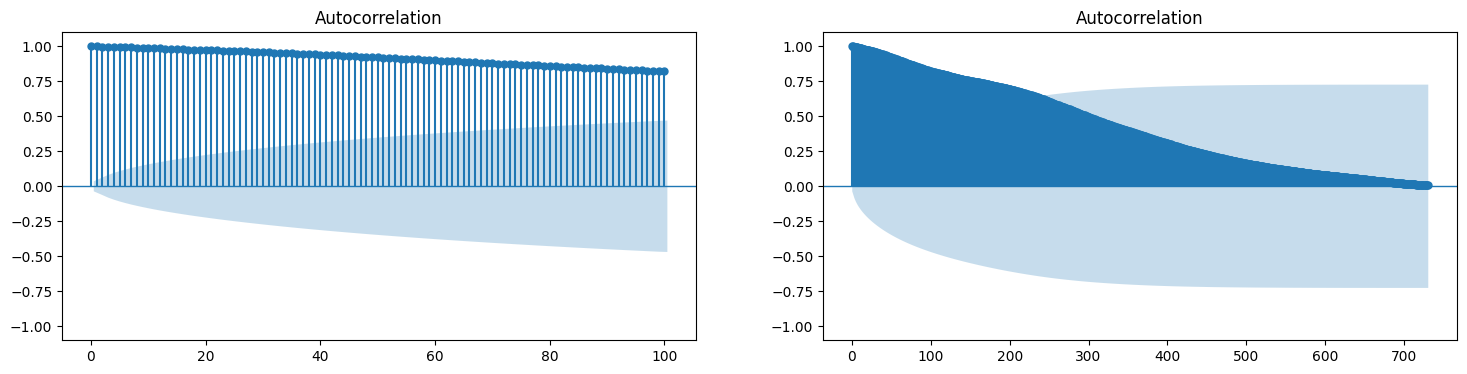

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 4))
axes = axes.flat
plot_acf(datos[column], ax=axes[0], linewidth = 1, lags=100)
axes[0].set_ylim(-1.1, 1.1)
plot_acf(datos[column], ax=axes[1], linewidth = 1, lags=730)
axes[1].set_ylim(-1.1, 1.1)
plt.show()

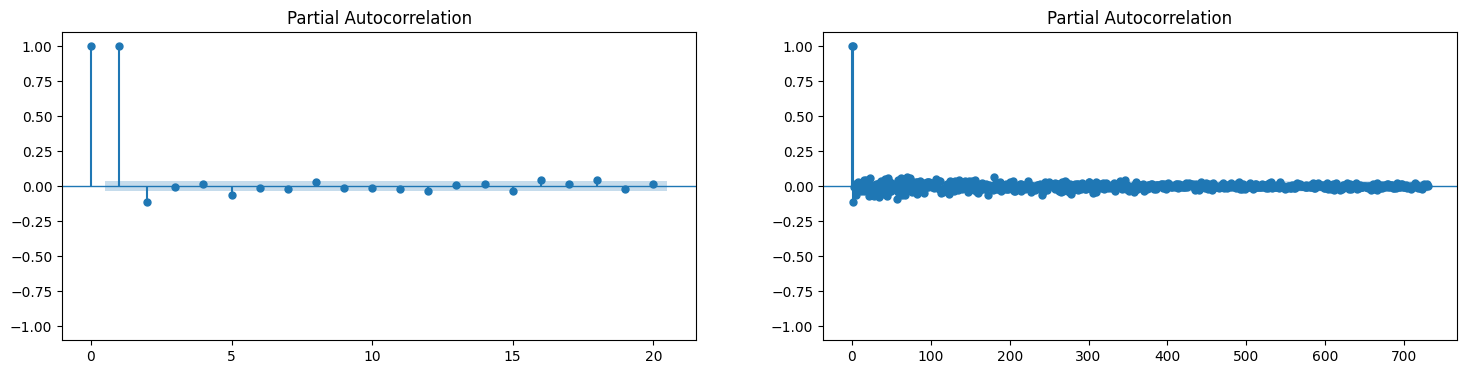

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 4))
axes = axes.flat
plot_pacf(datos[column], ax=axes[0], lags=20, method='ywm',  linewidth = 1) # ywm = Yule-Walker without adjustment
axes[0].set_ylim(-1.1, 1.1)
plot_pacf(datos[column], ax=axes[1], lags=730, method='ywm',  linewidth = 1)
axes[1].set_ylim(-1.1, 1.1)
plt.show()

## Entrenamiento

### Seleccion de fechas para entrenamiento y pruebas

In [16]:
start_train, end_train, start_test, end_test = getLimitDates(datos, 600, 2500) # 600 dias para test y 2500 para train

print(f"Historial completo      : {datos.index.min()} --- {datos.index.max()}  (n={len(datos)})")
print(f"Fechas de entrenamiento : {datos.loc[start_train:end_train].index.min()} --- {datos.loc[start_train:end_train].index.max()}  (n={len(datos.loc[start_train:end_train])})")
print(f"Fechas de prueba        : {datos.loc[start_test:].index.min()} --- {datos.loc[start_test:].index.max()}  (n={len(datos.loc[start_test:])})")

Historial completo      : 2014-09-17 00:00:00 --- 2022-09-24 00:00:00  (n=2930)
Fechas de entrenamiento : 2014-09-17 00:00:00 --- 2021-02-01 00:00:00  (n=2330)
Fechas de prueba        : 2021-02-02 00:00:00 --- 2022-09-24 00:00:00  (n=600)


### Modelo autoregresivo recursivo

## Evaluacion

### 1 Dia

Forecaster will be fit 600 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 

Forecaster will be fit 600 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 

Forecaster will be fit 600 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 

Forecaster will be fit 600 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 

Forecaster will be fit 600 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 

Forecaster will be fit 600 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 

Forecaster will be fit 600 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 

Forecaster will be fit 600 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 



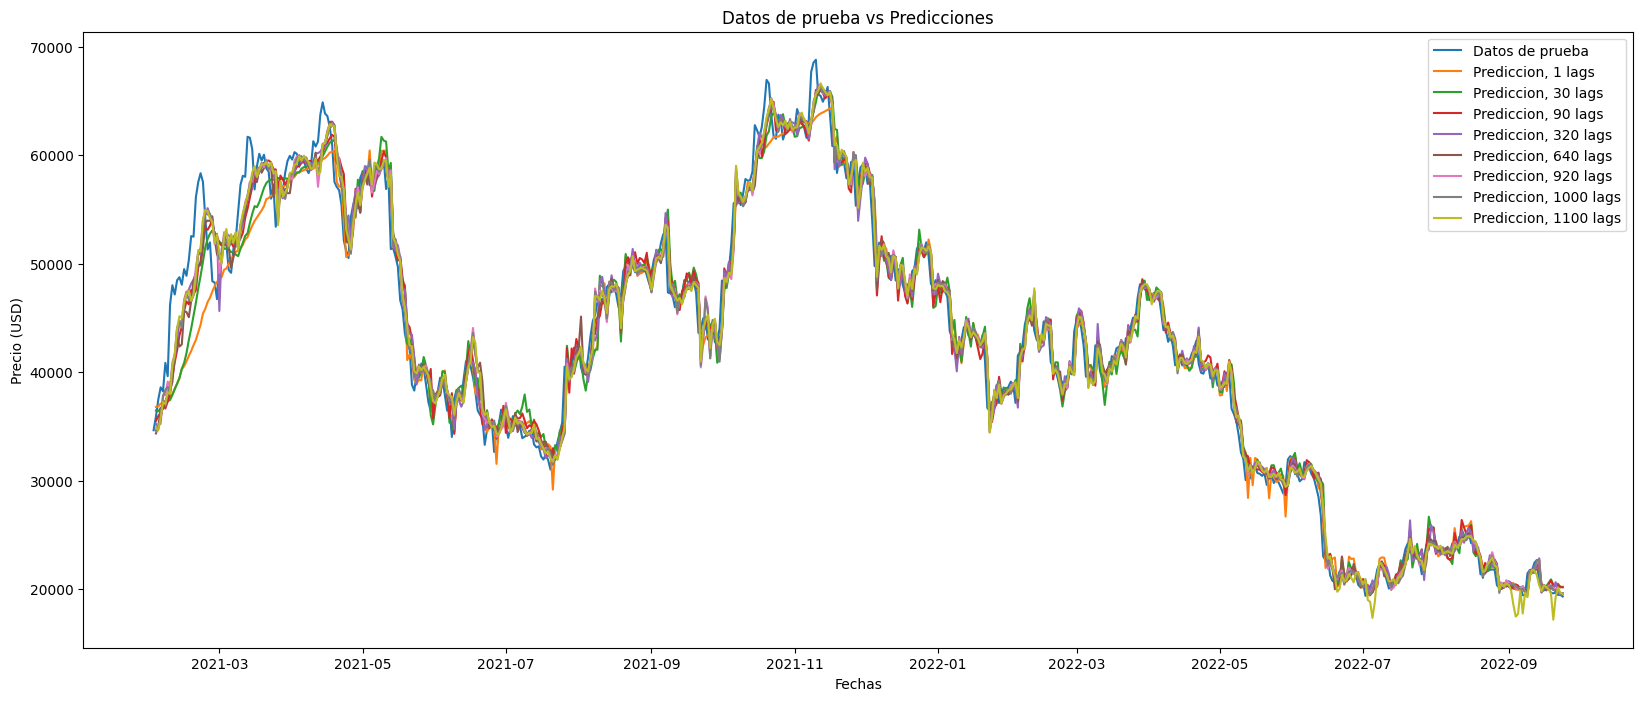

model  lags   test_error
0  LGBMRegressor     1  1511.033797
1  LGBMRegressor    30  1550.423261
2  LGBMRegressor    90  1380.792585
3  LGBMRegressor   320  1310.108730
4  LGBMRegressor   640  1289.033059
5  LGBMRegressor   920  1283.283984
6  LGBMRegressor  1000  1272.990679
7  LGBMRegressor  1100  1298.621332

In [17]:
steps = 1
lags = [1, 30, 90, 320, 640, 920, 1000, 1100]
forecasters = train_and_show_predictions_and_errors(datos, start_train, end_train, column, lags, steps)

In [18]:
# Haciendo prediccion con el forecaster de 920 lags
print(forecasters[6].predict(10))

2021-02-02    34545.289901
2021-02-03    34582.066325
2021-02-04    34890.727408
2021-02-05    35043.393334
2021-02-06    35043.393334
2021-02-07    34683.349810
2021-02-08    34604.379464
2021-02-09    34845.742142
2021-02-10    34977.474833
2021-02-11    34977.474833
Freq: D, Name: pred, dtype: float64


### 14 Dias

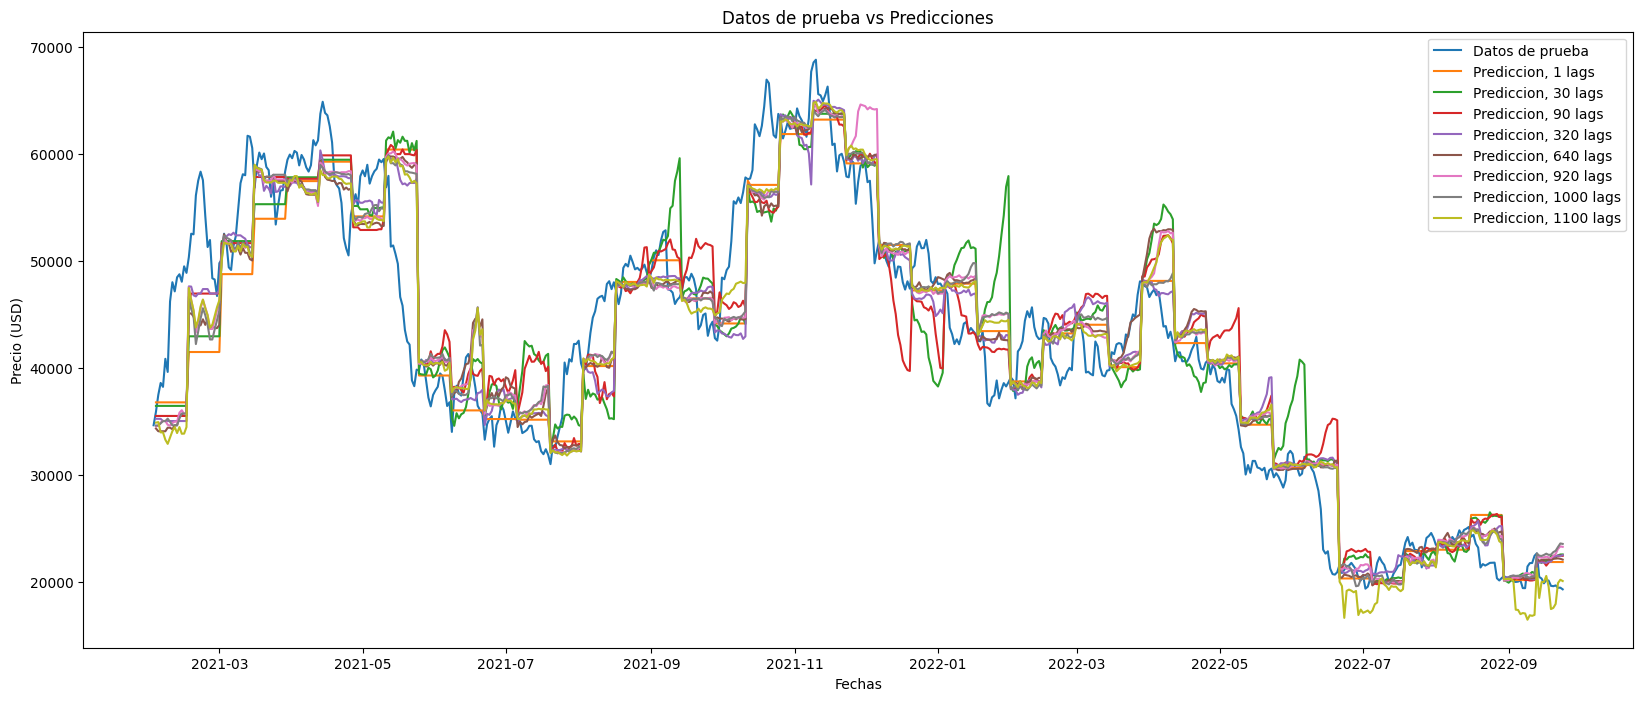

model  lags   test_error
0  LGBMRegressor     1  3405.633924
1  LGBMRegressor    30  4259.638343
2  LGBMRegressor    90  3899.240304
3  LGBMRegressor   320  3376.296980
4  LGBMRegressor   640  3479.241381
5  LGBMRegressor   920  3527.861456
6  LGBMRegressor  1000  3415.106953
7  LGBMRegressor  1100  3445.080899

In [19]:
steps = 14
lags = [1, 30, 90, 320, 640, 920, 1000, 1100]
forecasters = train_and_show_predictions_and_errors(datos, start_train, end_train, column, lags, steps)

### 1 Mes

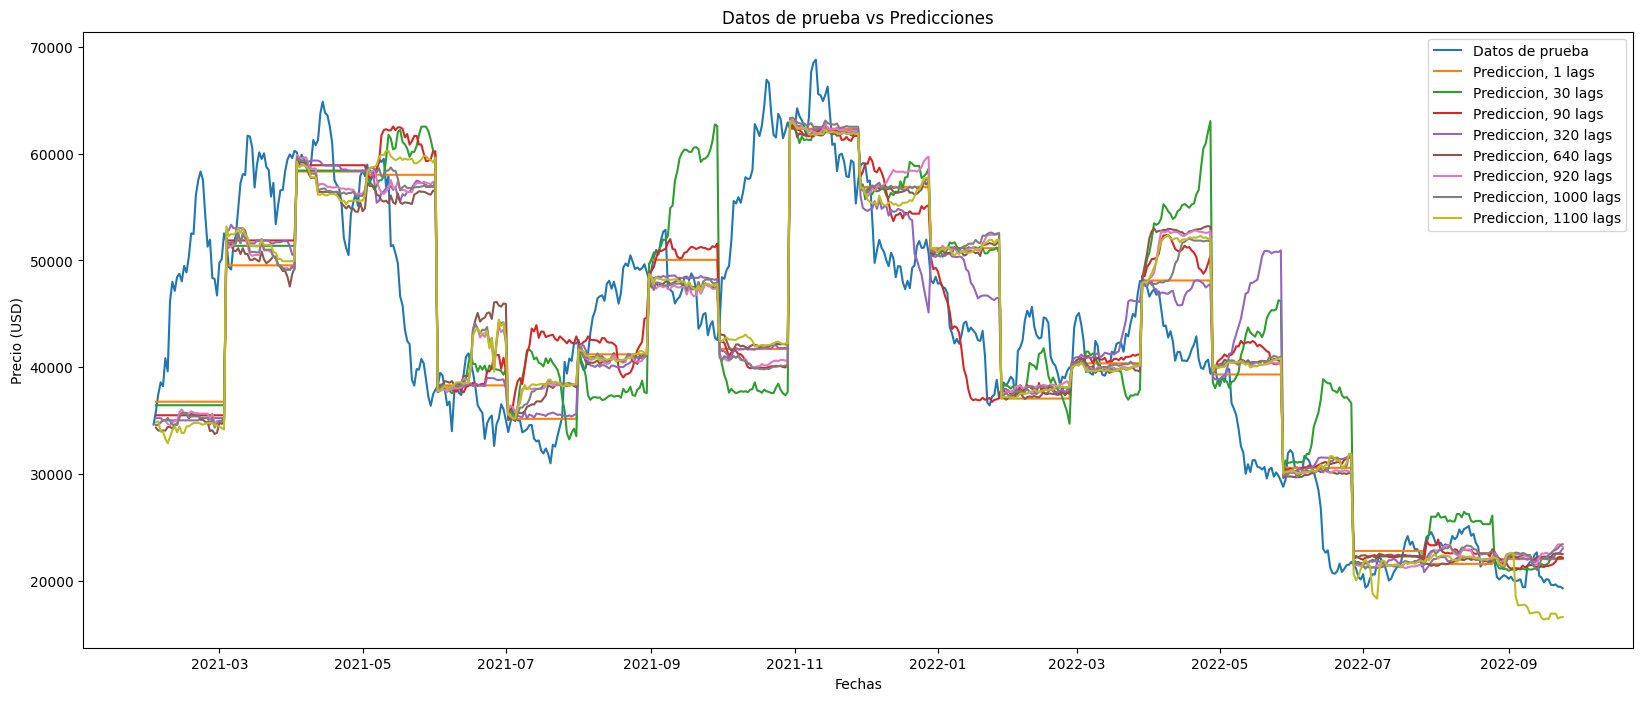

model  lags   test_error
0  LGBMRegressor     1  5332.673236
1  LGBMRegressor    30  6890.473026
2  LGBMRegressor    90  5478.364853
3  LGBMRegressor   320  5294.687739
4  LGBMRegressor   640  5749.557041
5  LGBMRegressor   920  5704.277254
6  LGBMRegressor  1000  5618.770703
7  LGBMRegressor  1100  5706.163245

In [20]:
steps = 30
lags = [1, 30, 90, 320, 640, 920, 1000, 1100]
forecasters = train_and_show_predictions_and_errors(datos, start_train, end_train, column, lags, steps)

### 6 Meses

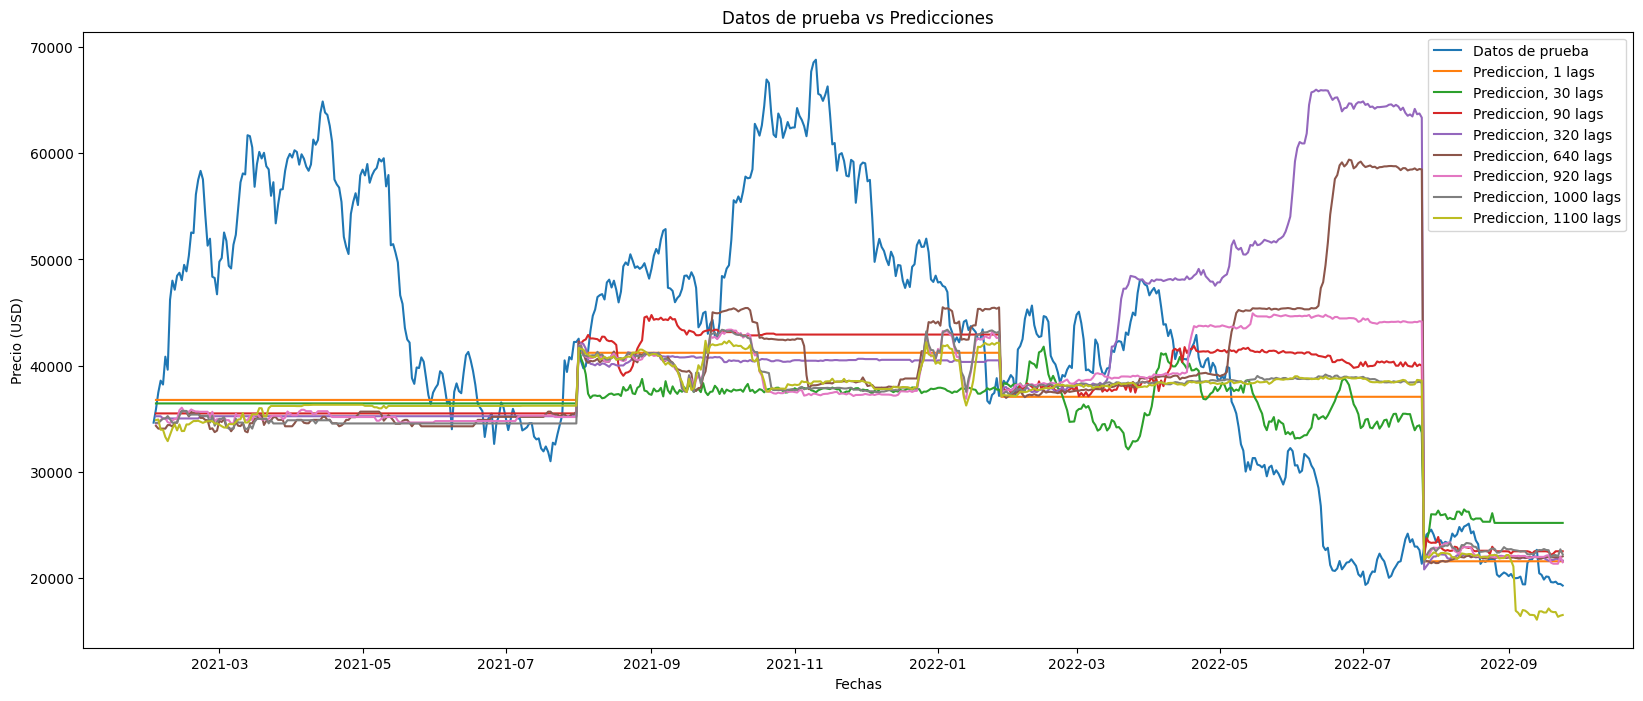

model  lags    test_error
0  LGBMRegressor     1   9147.866956
1  LGBMRegressor    30  10095.814411
2  LGBMRegressor    90   9245.812135
3  LGBMRegressor   320  12657.904853
4  LGBMRegressor   640  11547.361462
5  LGBMRegressor   920  10703.006362
6  LGBMRegressor  1000   9988.896948
7  LGBMRegressor  1100   9922.681270

In [21]:
steps = 180
lags = [1, 30, 90, 320, 640, 920, 1000, 1100]
forecasters = train_and_show_predictions_and_errors(datos, start_train, end_train, column, lags, steps)

### 1 Año

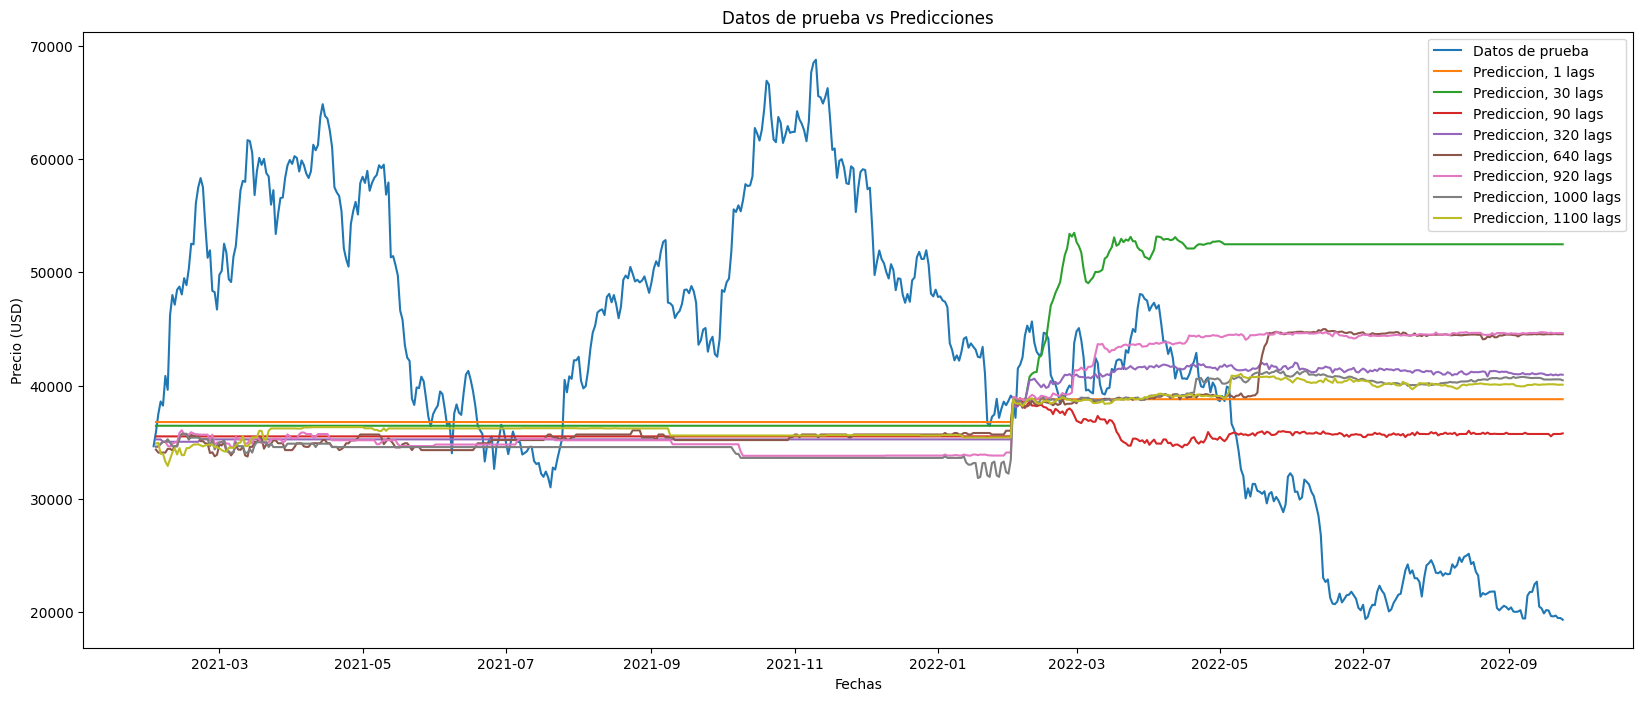

model  lags    test_error
0  LGBMRegressor     1  11887.506315
1  LGBMRegressor    30  16086.397620
2  LGBMRegressor    90  12168.259247
3  LGBMRegressor   320  13068.572527
4  LGBMRegressor   640  13908.763250
5  LGBMRegressor   920  14242.539469
6  LGBMRegressor  1000  13587.177802
7  LGBMRegressor  1100  12779.216866

In [22]:
steps = 365
lags = [1, 30, 90, 320, 640, 920, 1000, 1100]
forecasters = train_and_show_predictions_and_errors(datos, start_train, end_train, column, lags, steps)

# Ethereum

## Obtencion de los datos

In [81]:
# url para decargar todos los registros de Yahoo Finance, la fecha final es el dia de hoy menos un dia (ayer)
url = 'https://query1.finance.yahoo.com/v7/finance/download/ETH-USD?period1=1410825600&period2=' + getYesterdayEpoch() + '&interval=1d&events=history&includeAdjustedClose=true'

datos = downloadFile(url)
datos.info()
display(datos)
print(f"Fecha inicio datos: {datos.index.min()}")
print(f"Fecha fin datos: {datos.index.max()}")

<class 'pandas.core.frame.DataFrame'>
Index: 1782 entries, 2017-11-09 to 2022-09-25
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1782 non-null   float64
 1   High       1782 non-null   float64
 2   Low        1782 non-null   float64
 3   Close      1782 non-null   float64
 4   Adj Close  1782 non-null   float64
 5   Volume     1782 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 97.5+ KB


Open         High          Low        Close    Adj Close  \
Date                                                                          
2017-11-09   308.644989   329.451996   307.056000   320.884003   320.884003   
2017-11-10   320.670990   324.717987   294.541992   299.252991   299.252991   
2017-11-11   298.585999   319.453003   298.191986   314.681000   314.681000   
2017-11-12   314.690002   319.153015   298.513000   307.907990   307.907990   
2017-11-13   307.024994   328.415009   307.024994   316.716003   316.716003   
...                 ...          ...          ...          ...          ...   
2022-09-21  1324.215576  1384.476929  1229.426758  1252.607788  1252.607788   
2022-09-22  1251.567383  1336.157837  1240.968262  1327.680176  1327.680176   
2022-09-23  1327.481201  1353.288330  1270.198364  1328.259521  1328.259521   
2022-09-24  1328.244629  1346.255249  1312.640259  1317.993286  1317.993286   
2022-09-25  1317.938477  1333.371338  1275.627686  1294.216797  1294.216797   

                 Volume  
Date                     
2017-11-09    893249984  
2017-11-10    885985984  
2017-11-11    842300992  
2017-11-12   1613479936  
2017-11-13   1041889984  
...                 ...  
2022-09-21  20643507800  
2022-09-22  18461527259  
2022-09-23  18771106339  
2022-09-24  12098209717  
2022-09-25  11802651633  

[1782 rows x 6 columns]

Fecha inicio datos: 2017-11-09
Fecha fin datos: 2022-09-25


## Preparacion de los datos

In [70]:
column = 'High' # <--- Columna de valores a usar
datos['Date'] = pd.to_datetime(datos.index, format='%Y-%m-%d %H:%M:%S')
datos = datos.loc[:, ['Date', column]]
datos = datos.set_index('Date')
datos = datos.asfreq('D')
datos = datos.sort_index()
datos.head

<bound method NDFrame.head of                    High
Date                   
2017-11-09   329.451996
2017-11-10   324.717987
2017-11-11   319.453003
2017-11-12   319.153015
2017-11-13   328.415009
...                 ...
2022-09-21  1384.476929
2022-09-22  1336.157837
2022-09-23  1353.288330
2022-09-24  1346.255249
2022-09-25  1333.371338

[1782 rows x 1 columns]>

In [71]:
# Verificar datos faltantes
print(f'Numero de filas con valores faltantes: {datos.isnull().any(axis=1).mean()}')

Numero de filas con valores faltantes: 0.0


### Analisis de datos

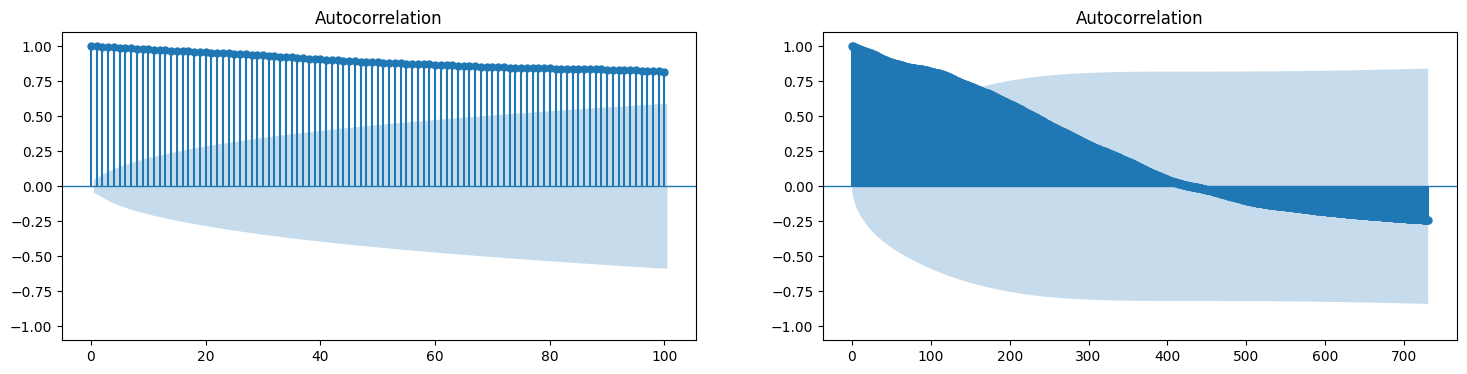

In [72]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 4))
axes = axes.flat
plot_acf(datos[column], ax=axes[0], linewidth = 1, lags=100)
axes[0].set_ylim(-1.1, 1.1)
plot_acf(datos[column], ax=axes[1], linewidth = 1, lags=730)
axes[1].set_ylim(-1.1, 1.1)
plt.show()

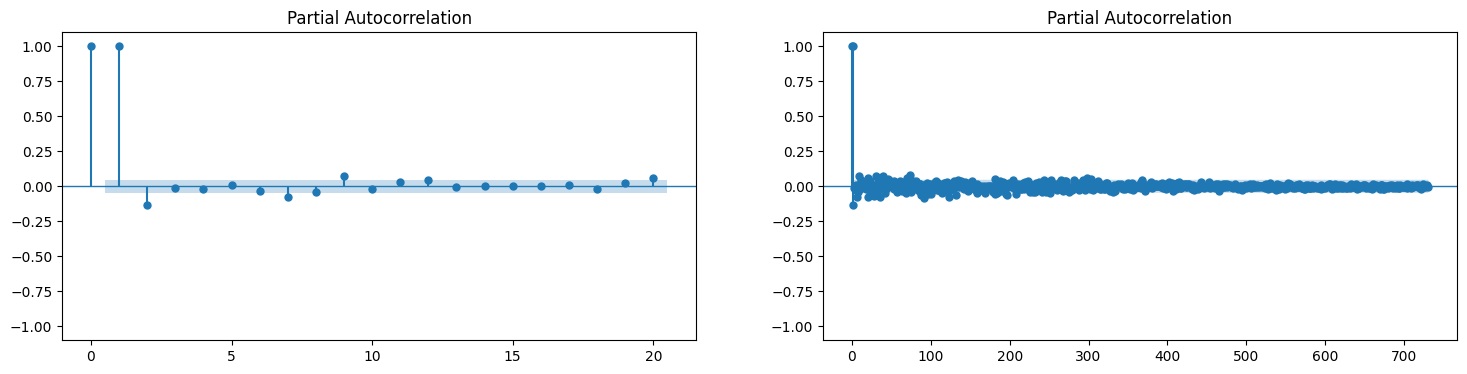

In [73]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 4))
axes = axes.flat
plot_pacf(datos[column], ax=axes[0], lags=20, method='ywm',  linewidth = 1) # ywm = Yule-Walker without adjustment
axes[0].set_ylim(-1.1, 1.1)
plot_pacf(datos[column], ax=axes[1], lags=730, method='ywm',  linewidth = 1)
axes[1].set_ylim(-1.1, 1.1)
plt.show()

## Entrenamiento

### Seleccion de fechas para entrenamiento y pruebas

In [74]:
start_train, end_train, start_test, end_test = getLimitDates(datos, 200, 1600) # 500 dias para test y 1300 para train

print(f"Historial completo      : {datos.index.min()} --- {datos.index.max()}  (n={len(datos)})")
print(f"Fechas de entrenamiento : {datos.loc[start_train:end_train].index.min()} --- {datos.loc[start_train:end_train].index.max()}  (n={len(datos.loc[start_train:end_train])})")
print(f"Fechas de prueba        : {datos.loc[start_test:].index.min()} --- {datos.loc[start_test:].index.max()}  (n={len(datos.loc[start_test:])})")

Historial completo      : 2017-11-09 00:00:00 --- 2022-09-25 00:00:00  (n=1782)
Fechas de entrenamiento : 2017-11-09 00:00:00 --- 2022-03-09 00:00:00  (n=1582)
Fechas de prueba        : 2022-03-10 00:00:00 --- 2022-09-25 00:00:00  (n=200)


### Modelo autoregresivo recursivo

## Evaluacion

### 1 Dia

Forecaster will be fit 200 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 

Forecaster will be fit 200 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 

Forecaster will be fit 200 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 

Forecaster will be fit 200 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 

Forecaster will be fit 200 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 

Forecaster will be fit 200 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 

Forecaster will be fit 200 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 



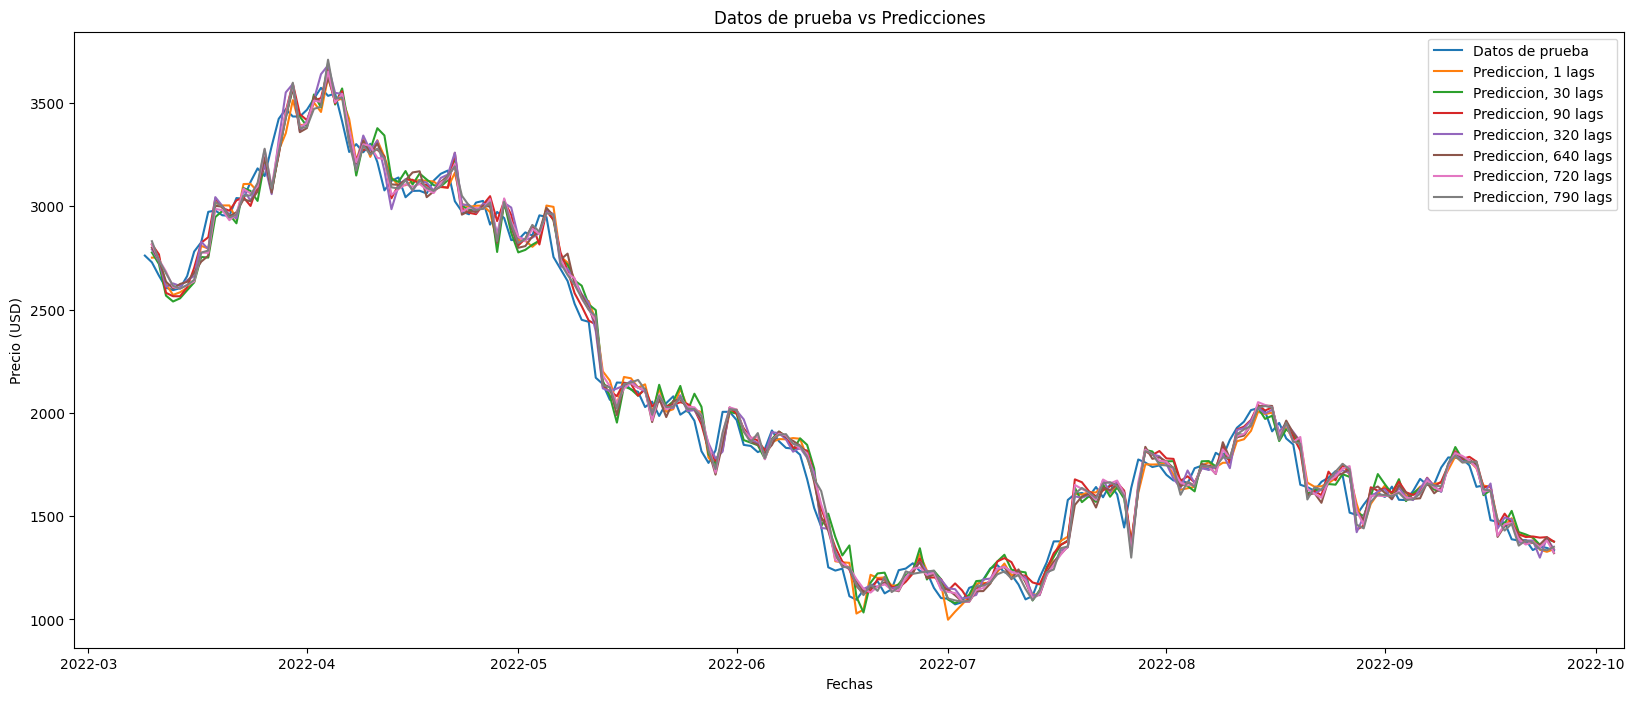

model  lags  test_error
0  LGBMRegressor     1   64.406961
1  LGBMRegressor    30   70.010865
2  LGBMRegressor    90   62.525387
3  LGBMRegressor   320   61.747334
4  LGBMRegressor   640   65.552212
5  LGBMRegressor   720   62.965199
6  LGBMRegressor   790   62.475351

In [75]:
steps = 1
lags = [1, 30, 90, 320, 640, 720, 790]
forecasters = train_and_show_predictions_and_errors(datos, start_train, end_train, column, lags, steps)

In [76]:
# Haciendo prediccion con el forecaster de 920 lags
print(forecasters[6].predict(10))

2022-03-10    2816.066246
2022-03-11    2794.789413
2022-03-12    2777.097054
2022-03-13    2782.165882
2022-03-14    2784.335464
2022-03-15    2810.590809
2022-03-16    2778.378447
2022-03-17    2769.895028
2022-03-18    2768.539062
2022-03-19    2773.529071
Freq: D, Name: pred, dtype: float64


### 14 Dias

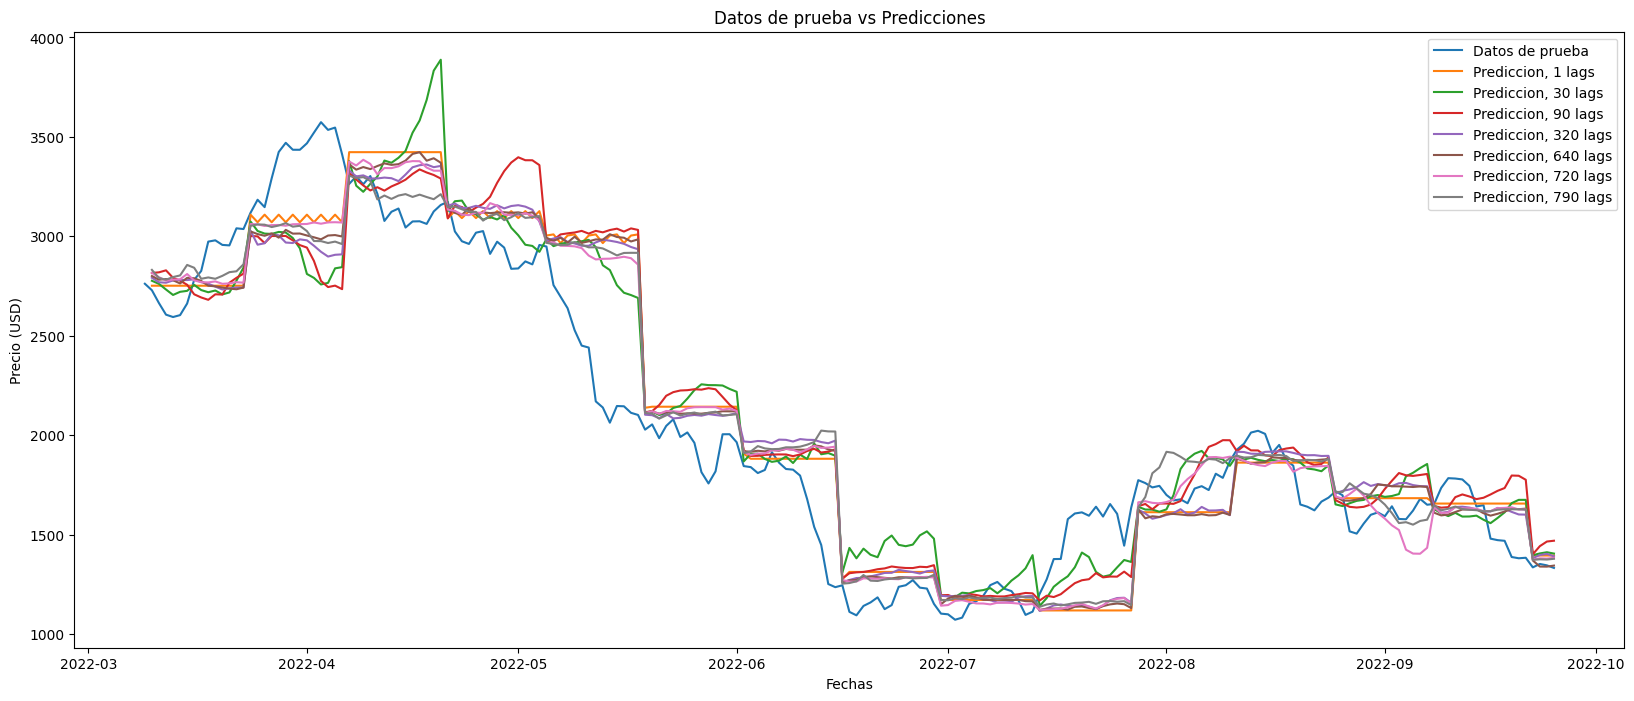

model  lags  test_error
0  LGBMRegressor     1  206.303432
1  LGBMRegressor    30  216.621095
2  LGBMRegressor    90  224.624006
3  LGBMRegressor   320  212.836432
4  LGBMRegressor   640  209.598311
5  LGBMRegressor   720  194.977970
6  LGBMRegressor   790  190.016829

In [77]:
steps = 14
forecasters = train_and_show_predictions_and_errors(datos, start_train, end_train, column, lags, steps)

### 1 Mes

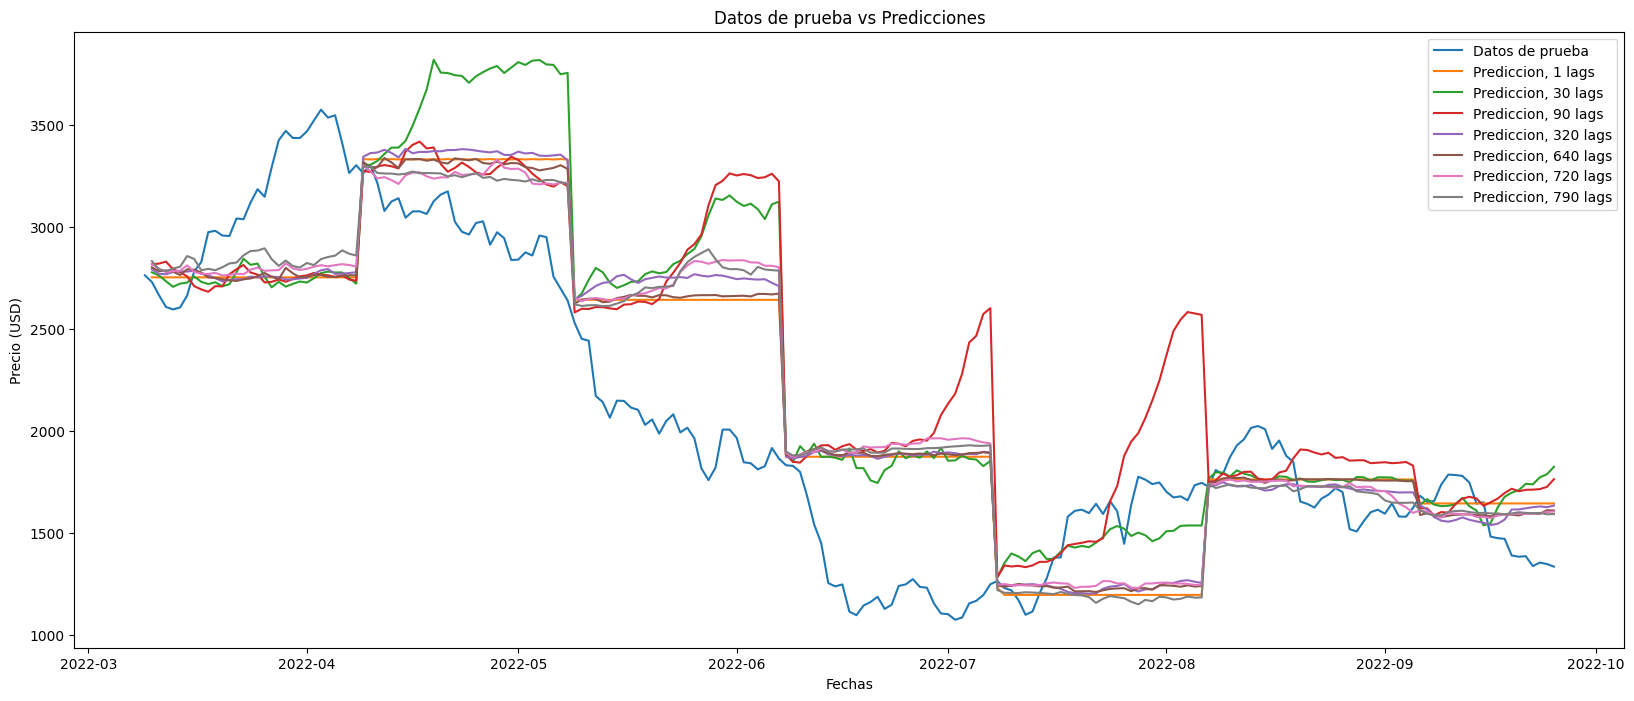

model  lags  test_error
0  LGBMRegressor     1  379.034805
1  LGBMRegressor    30  441.742971
2  LGBMRegressor    90  443.597085
3  LGBMRegressor   320  395.124415
4  LGBMRegressor   640  377.954738
5  LGBMRegressor   720  377.841476
6  LGBMRegressor   790  375.979560

In [78]:
steps = 30
forecasters = train_and_show_predictions_and_errors(datos, start_train, end_train, column, lags, steps)

### 6 Meses

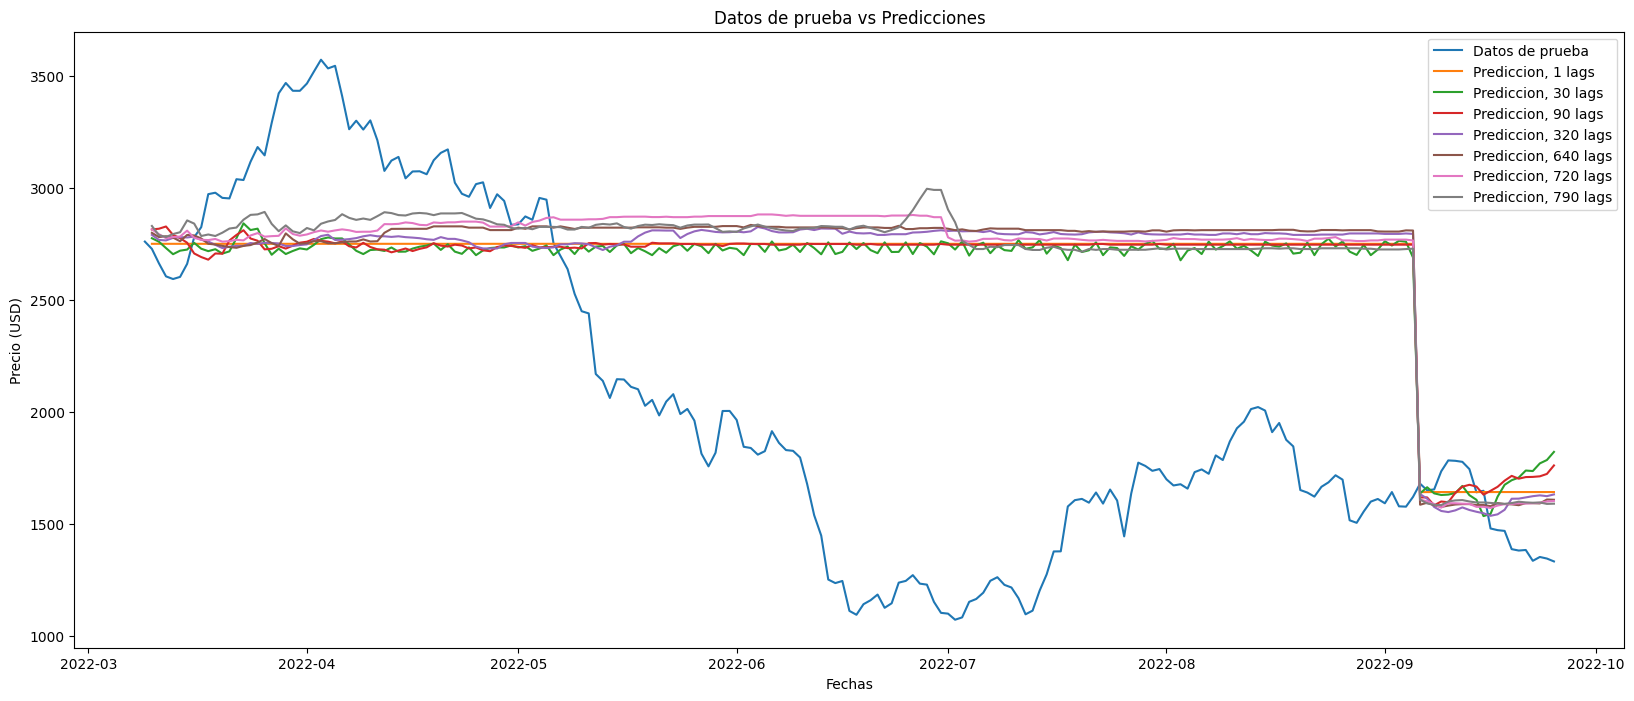

model  lags  test_error
0  LGBMRegressor     1  782.868287
1  LGBMRegressor    30  778.552849
2  LGBMRegressor    90  789.082072
3  LGBMRegressor   320  809.627955
4  LGBMRegressor   640  815.418315
5  LGBMRegressor   720  808.162151
6  LGBMRegressor   790  778.569954

In [79]:
steps = 180
forecasters = train_and_show_predictions_and_errors(datos, start_train, end_train, column, lags, steps)

### 1 Año

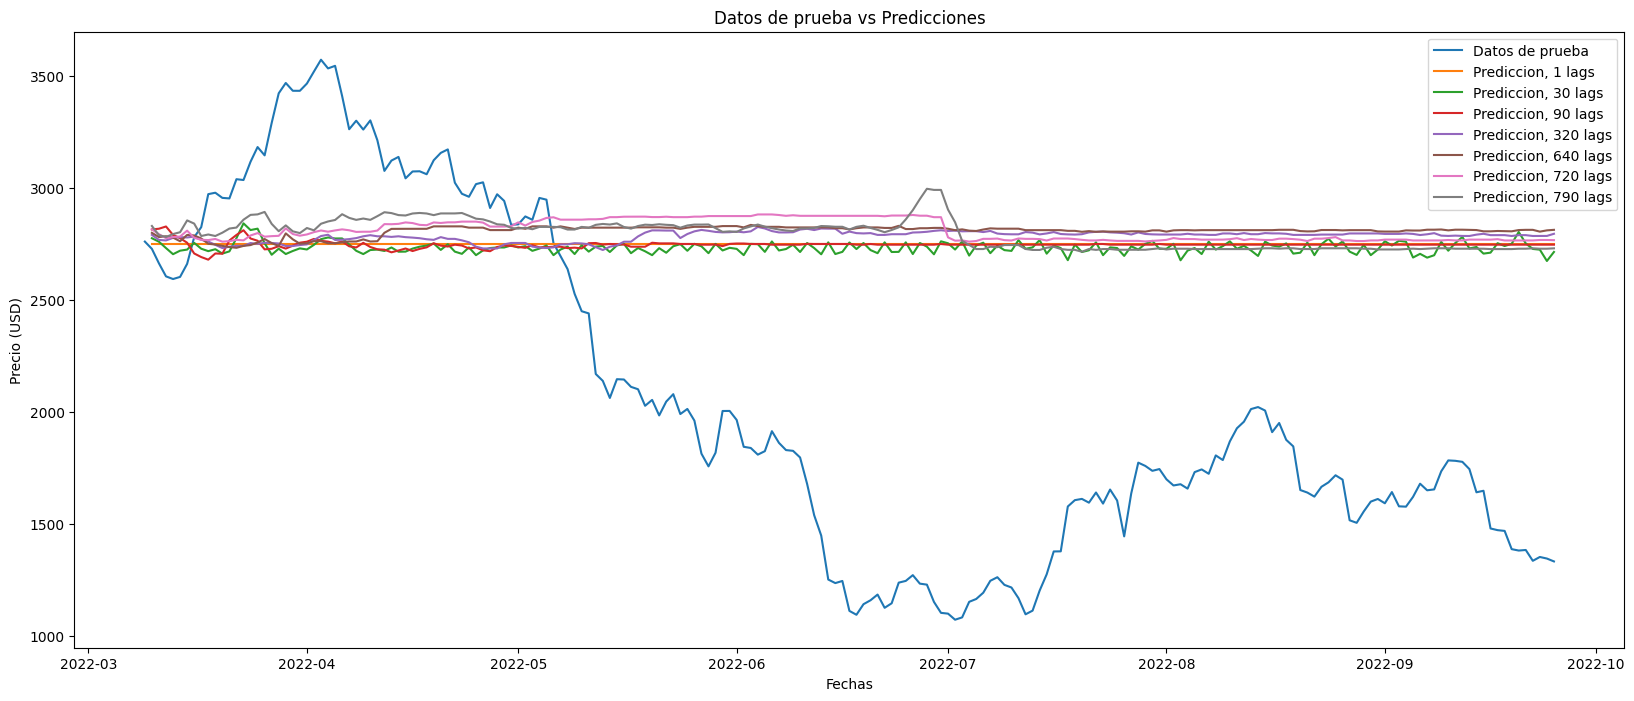

model  lags  test_error
0  LGBMRegressor     1  886.991325
1  LGBMRegressor    30  876.559662
2  LGBMRegressor    90  888.844388
3  LGBMRegressor   320  916.315703
4  LGBMRegressor   640  925.210463
5  LGBMRegressor   720  913.866504
6  LGBMRegressor   790  880.722062

In [80]:
steps = 365
forecasters = train_and_show_predictions_and_errors(datos, start_train, end_train, column, lags, steps)

# Cardano

## Obtencion de los datos

In [97]:
# url para decargar todos los registros de Yahoo Finance, la fecha final es el dia de hoy menos un dia (ayer)
url = 'https://query1.finance.yahoo.com/v7/finance/download/ADA-USD?period1=1410825600&period2=' + getYesterdayEpoch() + '&interval=1d&events=history&includeAdjustedClose=true'

datos = downloadFile(url)
datos.info()
display(datos)
print(f"Fecha inicio datos: {datos.index.min()}")
print(f"Fecha fin datos: {datos.index.max()}")

<class 'pandas.core.frame.DataFrame'>
Index: 1782 entries, 2017-11-09 to 2022-09-25
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1782 non-null   float64
 1   High       1782 non-null   float64
 2   Low        1782 non-null   float64
 3   Close      1782 non-null   float64
 4   Adj Close  1782 non-null   float64
 5   Volume     1782 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 97.5+ KB


Open      High       Low     Close  Adj Close      Volume
Date                                                                     
2017-11-09  0.025160  0.035060  0.025006  0.032053   0.032053    18716200
2017-11-10  0.032219  0.033348  0.026451  0.027119   0.027119     6766780
2017-11-11  0.026891  0.029659  0.025684  0.027437   0.027437     5532220
2017-11-12  0.027480  0.027952  0.022591  0.023977   0.023977     7280250
2017-11-13  0.024364  0.026300  0.023495  0.025808   0.025808     4419440
...              ...       ...       ...       ...        ...         ...
2022-09-21  0.441951  0.461842  0.432546  0.441159   0.441159  1223771049
2022-09-22  0.440876  0.465499  0.435710  0.458966   0.458966   762487961
2022-09-23  0.458951  0.479108  0.448352  0.461821   0.461821  1025328778
2022-09-24  0.461830  0.467096  0.451294  0.451600   0.451600   582129449
2022-09-25  0.451599  0.461773  0.440216  0.446188   0.446188   528836100

[1782 rows x 6 columns]

Fecha inicio datos: 2017-11-09
Fecha fin datos: 2022-09-25


## Preparacion de los datos

In [98]:
column = 'High' # <--- Columna de valores a usar
datos['Date'] = pd.to_datetime(datos.index, format='%Y-%m-%d %H:%M:%S')
datos = datos.loc[:, ['Date', column]]
datos = datos.set_index('Date')
datos = datos.asfreq('D')
datos = datos.sort_index()
datos.head

<bound method NDFrame.head of                 High
Date                
2017-11-09  0.035060
2017-11-10  0.033348
2017-11-11  0.029659
2017-11-12  0.027952
2017-11-13  0.026300
...              ...
2022-09-21  0.461842
2022-09-22  0.465499
2022-09-23  0.479108
2022-09-24  0.467096
2022-09-25  0.461773

[1782 rows x 1 columns]>

In [99]:
# Verificar datos faltantes
print(f'Numero de filas con valores faltantes: {datos.isnull().any(axis=1).mean()}')

Numero de filas con valores faltantes: 0.0


### Analisis de datos

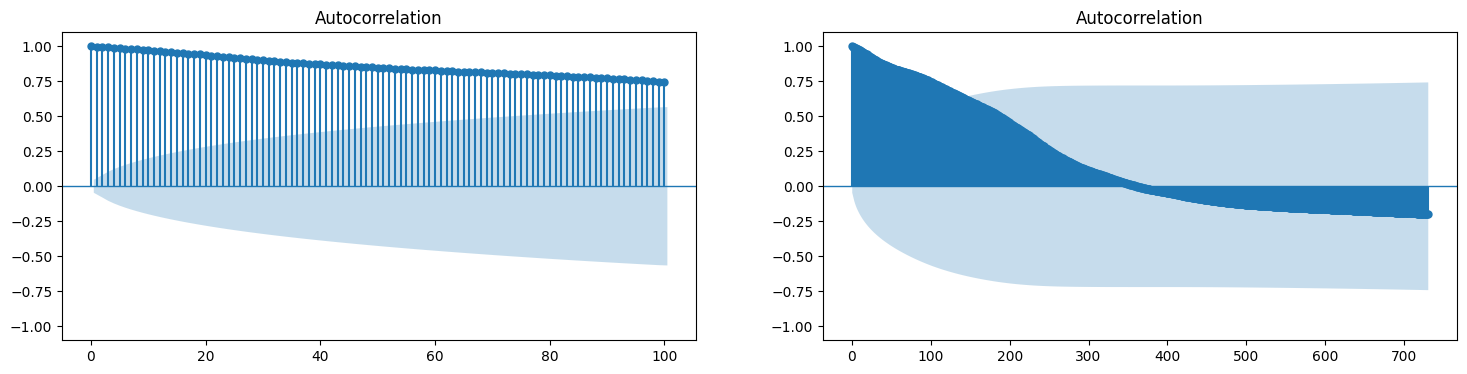

In [100]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 4))
axes = axes.flat
plot_acf(datos[column], ax=axes[0], linewidth = 1, lags=100)
axes[0].set_ylim(-1.1, 1.1)
plot_acf(datos[column], ax=axes[1], linewidth = 1, lags=730)
axes[1].set_ylim(-1.1, 1.1)
plt.show()

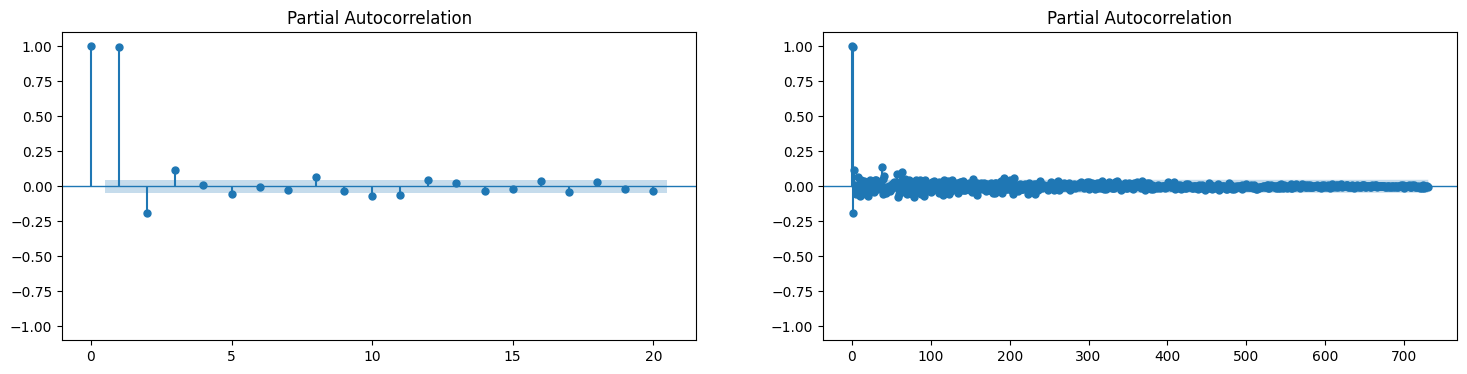

In [101]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 4))
axes = axes.flat
plot_pacf(datos[column], ax=axes[0], lags=20, method='ywm',  linewidth = 1) # ywm = Yule-Walker without adjustment
axes[0].set_ylim(-1.1, 1.1)
plot_pacf(datos[column], ax=axes[1], lags=730, method='ywm',  linewidth = 1)
axes[1].set_ylim(-1.1, 1.1)
plt.show()

## Entrenamiento

### Seleccion de fechas para entrenamiento y pruebas

In [102]:
start_train, end_train, start_test, end_test = getLimitDates(datos, 100, 1600) # 100 dias para test y 1600 para train

print(f"Historial completo      : {datos.index.min()} --- {datos.index.max()}  (n={len(datos)})")
print(f"Fechas de entrenamiento : {datos.loc[start_train:end_train].index.min()} --- {datos.loc[start_train:end_train].index.max()}  (n={len(datos.loc[start_train:end_train])})")
print(f"Fechas de prueba        : {datos.loc[start_test:].index.min()} --- {datos.loc[start_test:].index.max()}  (n={len(datos.loc[start_test:])})")

Historial completo      : 2017-11-09 00:00:00 --- 2022-09-25 00:00:00  (n=1782)
Fechas de entrenamiento : 2018-01-30 00:00:00 --- 2022-06-17 00:00:00  (n=1600)
Fechas de prueba        : 2022-06-18 00:00:00 --- 2022-09-25 00:00:00  (n=100)


### Modelo autoregresivo recursivo

## Evaluacion

### 1 Dia

Forecaster will be fit 100 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 

Forecaster will be fit 100 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 

Forecaster will be fit 100 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 

Forecaster will be fit 100 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 

Forecaster will be fit 100 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 

Forecaster will be fit 100 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 

Forecaster will be fit 100 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 



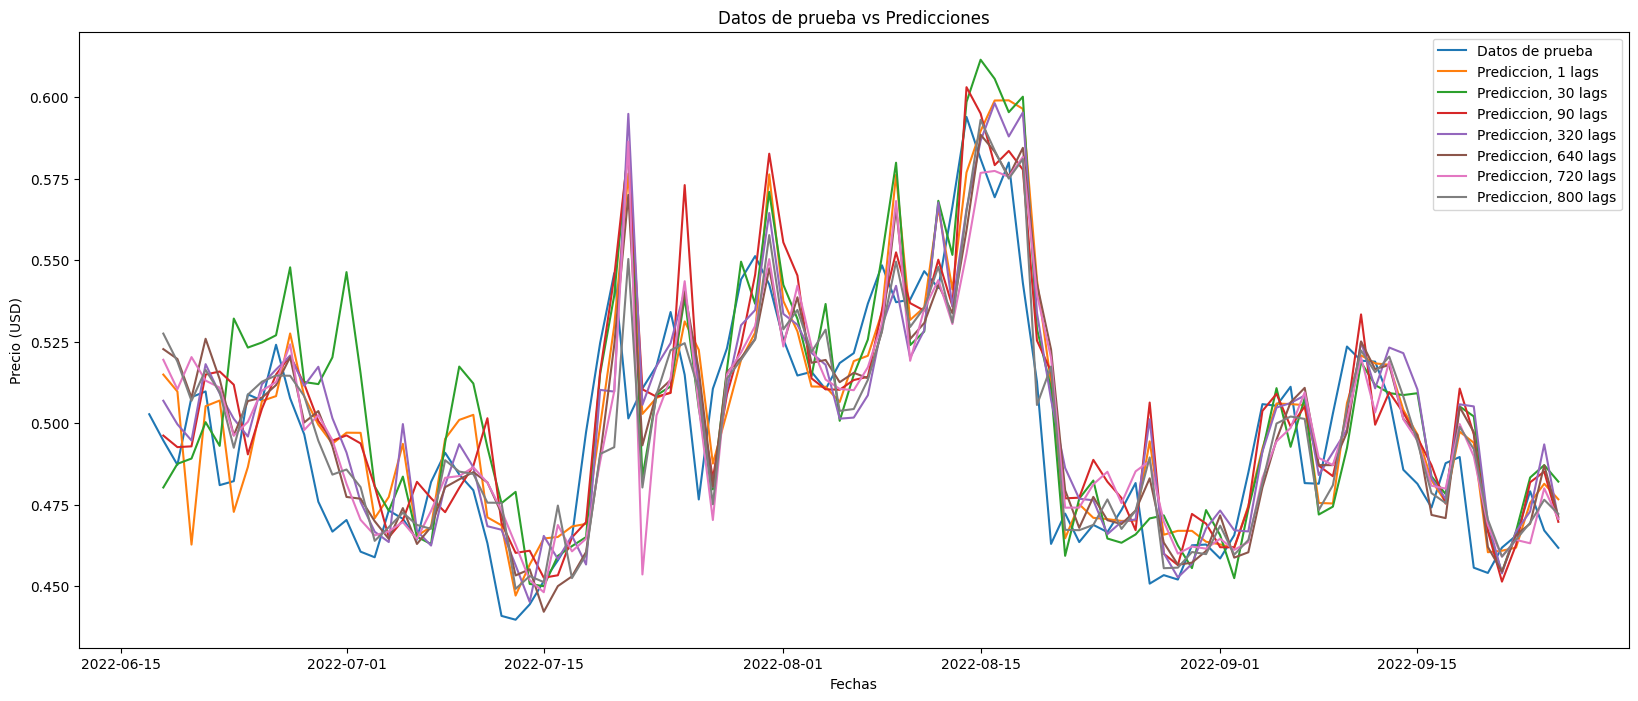

model  lags  test_error
0  LGBMRegressor     1    0.016371
1  LGBMRegressor    30    0.019143
2  LGBMRegressor    90    0.015941
3  LGBMRegressor   320    0.016662
4  LGBMRegressor   640    0.015642
5  LGBMRegressor   720    0.016164
6  LGBMRegressor   800    0.014778

In [103]:
steps = 1
lags = [1, 30, 90, 320, 640, 720, 800]
forecasters = train_and_show_predictions_and_errors(datos, start_train, end_train, column, lags, steps)

In [151]:
# Haciendo prediccion con el forecaster de 920 lags
print(forecasters[6].predict(10))

IndexError: list index out of range

### 14 Dias

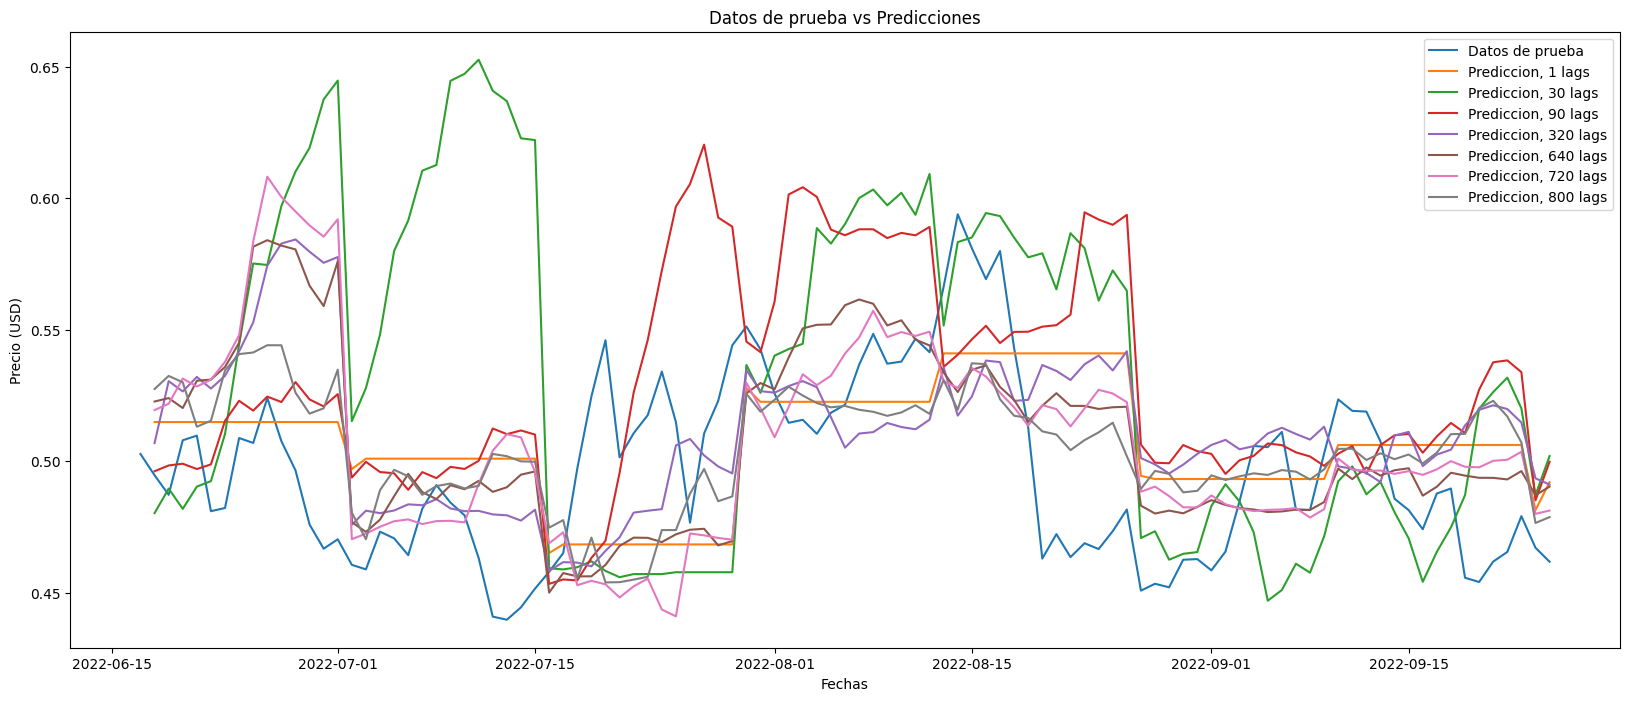

model  lags  test_error
0  LGBMRegressor     1    0.030563
1  LGBMRegressor    30    0.060105
2  LGBMRegressor    90    0.041603
3  LGBMRegressor   320    0.034273
4  LGBMRegressor   640    0.032621
5  LGBMRegressor   720    0.034979
6  LGBMRegressor   800    0.030124

In [105]:
steps = 14
forecasters = train_and_show_predictions_and_errors(datos, start_train, end_train, column, lags, steps)

### 1 Mes

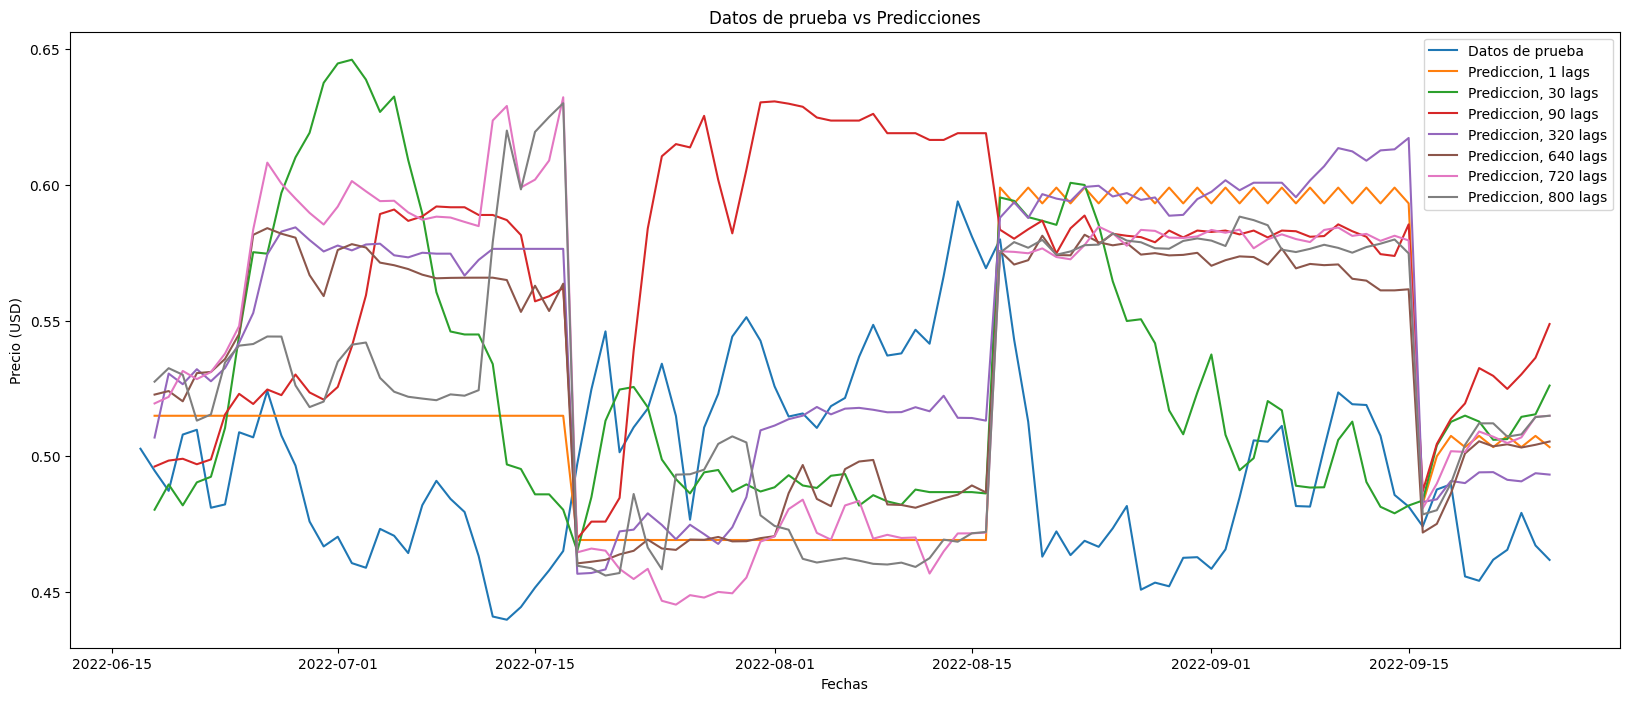

model  lags  test_error
0  LGBMRegressor     1    0.065760
1  LGBMRegressor    30    0.056912
2  LGBMRegressor    90    0.077267
3  LGBMRegressor   320    0.072412
4  LGBMRegressor   640    0.069345
5  LGBMRegressor   720    0.082535
6  LGBMRegressor   800    0.069144

In [106]:
steps = 30
forecasters = train_and_show_predictions_and_errors(datos, start_train, end_train, column, lags, steps)

### 6 Meses

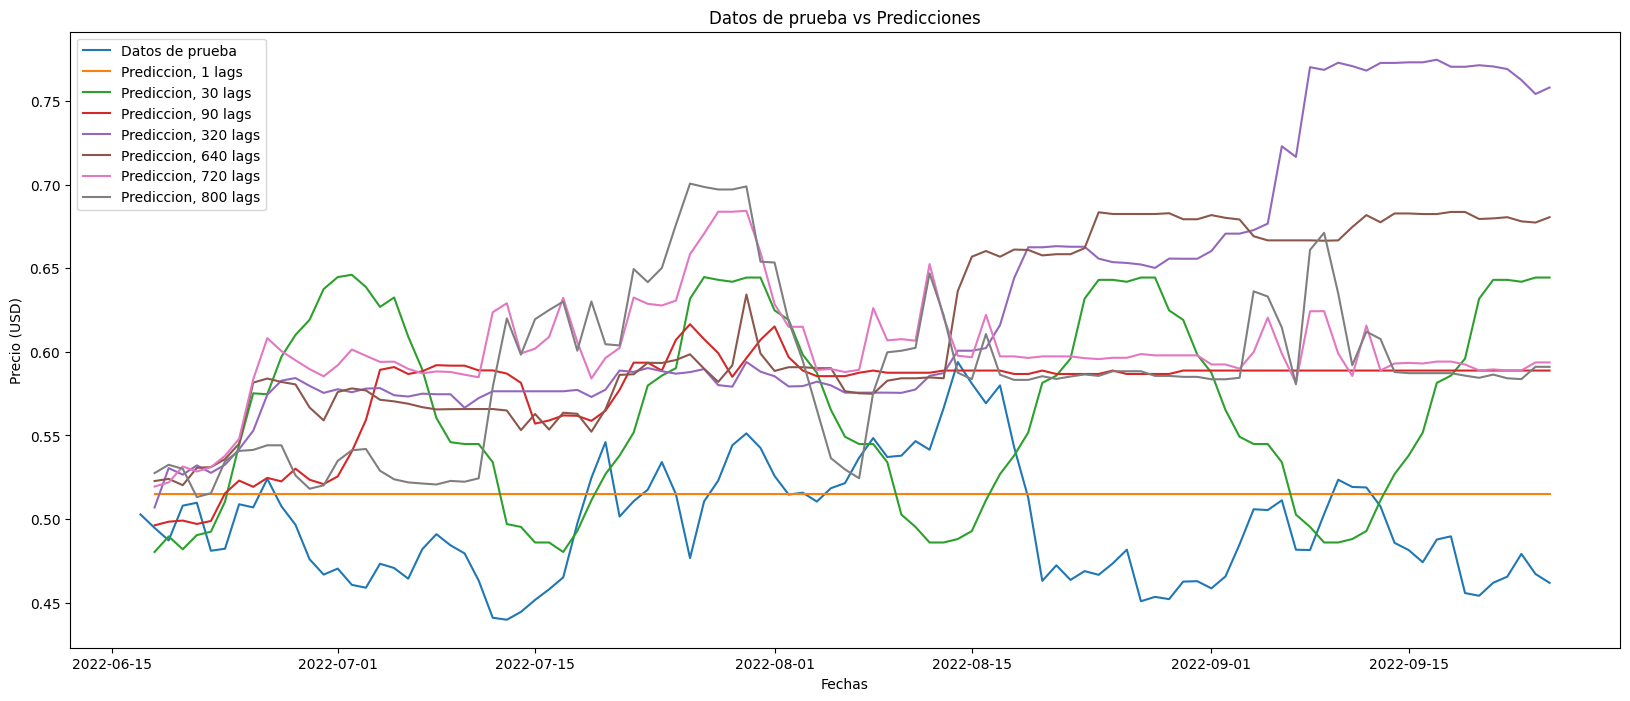

model  lags  test_error
0  LGBMRegressor     1    0.032758
1  LGBMRegressor    30    0.084618
2  LGBMRegressor    90    0.080877
3  LGBMRegressor   320    0.132541
4  LGBMRegressor   640    0.119272
5  LGBMRegressor   720    0.104116
6  LGBMRegressor   800    0.092366

In [107]:
steps = 180
forecasters = train_and_show_predictions_and_errors(datos, start_train, end_train, column, lags, steps)

### 1 Año

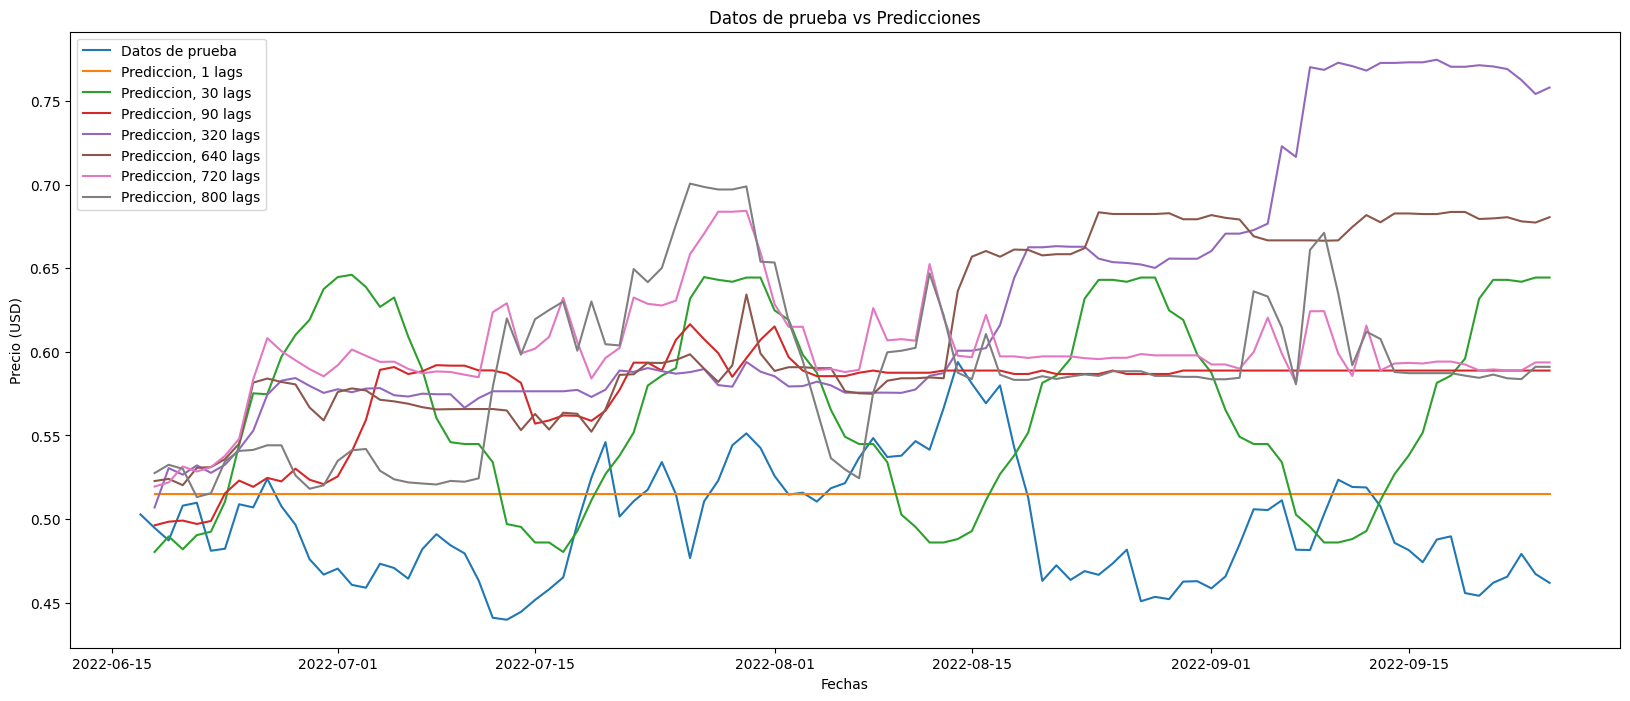

model  lags  test_error
0  LGBMRegressor     1    0.032758
1  LGBMRegressor    30    0.084618
2  LGBMRegressor    90    0.080877
3  LGBMRegressor   320    0.132541
4  LGBMRegressor   640    0.119272
5  LGBMRegressor   720    0.104116
6  LGBMRegressor   800    0.092366

In [108]:
steps = 365
forecasters = train_and_show_predictions_and_errors(datos, start_train, end_train, column, lags, steps)

# Ripple

## Obtencion de los datos

In [117]:
# url para decargar todos los registros de Yahoo Finance, la fecha final es el dia de hoy menos un dia (ayer)
url = 'https://query1.finance.yahoo.com/v7/finance/download/XRP-USD?period1=1410825600&period2=' + getYesterdayEpoch() + '&interval=1d&events=history&includeAdjustedClose=true'

datos = downloadFile(url)
datos.info()
display(datos)
print(f"Fecha inicio datos: {datos.index.min()}")
print(f"Fecha fin datos: {datos.index.max()}")

<class 'pandas.core.frame.DataFrame'>
Index: 1782 entries, 2017-11-09 to 2022-09-25
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1782 non-null   float64
 1   High       1782 non-null   float64
 2   Low        1782 non-null   float64
 3   Close      1782 non-null   float64
 4   Adj Close  1782 non-null   float64
 5   Volume     1782 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 97.5+ KB


Open      High       Low     Close  Adj Close      Volume
Date                                                                     
2017-11-09  0.217911  0.221791  0.214866  0.217488   0.217488   147916992
2017-11-10  0.218256  0.219068  0.205260  0.206483   0.206483   141032992
2017-11-11  0.205948  0.214456  0.205459  0.210430   0.210430   134503008
2017-11-12  0.210214  0.210214  0.195389  0.197339   0.197339   251175008
2017-11-13  0.197472  0.204081  0.197456  0.203442   0.203442   132567000
...              ...       ...       ...       ...        ...         ...
2022-09-21  0.415166  0.428325  0.388009  0.396828   0.396828  3401100359
2022-09-22  0.396538  0.491229  0.394785  0.485101   0.485101  4916275588
2022-09-23  0.485137  0.552283  0.458918  0.507171   0.507171  7798770582
2022-09-24  0.507200  0.515015  0.474019  0.488716   0.488716  3512953969
2022-09-25  0.488732  0.518314  0.478734  0.492627   0.492627  3422191941

[1782 rows x 6 columns]

Fecha inicio datos: 2017-11-09
Fecha fin datos: 2022-09-25


## Preparacion de los datos

In [118]:
column = 'High' # <--- Columna de valores a usar
datos['Date'] = pd.to_datetime(datos.index, format='%Y-%m-%d %H:%M:%S')
datos = datos.loc[:, ['Date', column]]
datos = datos.set_index('Date')
datos = datos.asfreq('D')
datos = datos.sort_index()
datos.head

<bound method NDFrame.head of                 High
Date                
2017-11-09  0.221791
2017-11-10  0.219068
2017-11-11  0.214456
2017-11-12  0.210214
2017-11-13  0.204081
...              ...
2022-09-21  0.428325
2022-09-22  0.491229
2022-09-23  0.552283
2022-09-24  0.515015
2022-09-25  0.518314

[1782 rows x 1 columns]>

In [119]:
# Verificar datos faltantes
print(f'Numero de filas con valores faltantes: {datos.isnull().any(axis=1).mean()}')

Numero de filas con valores faltantes: 0.0


### Analisis de datos

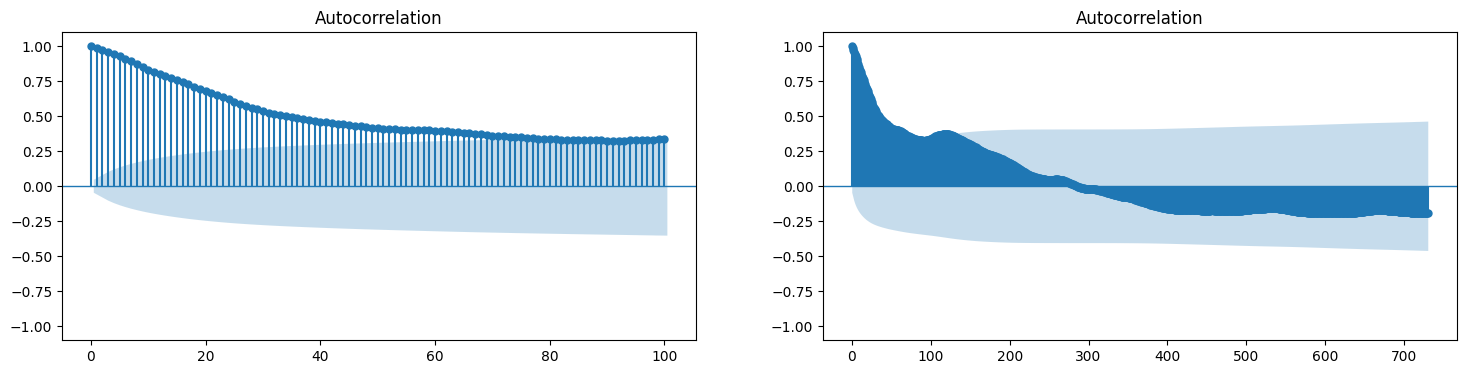

In [120]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 4))
axes = axes.flat
plot_acf(datos[column], ax=axes[0], linewidth = 1, lags=100)
axes[0].set_ylim(-1.1, 1.1)
plot_acf(datos[column], ax=axes[1], linewidth = 1, lags=730)
axes[1].set_ylim(-1.1, 1.1)
plt.show()

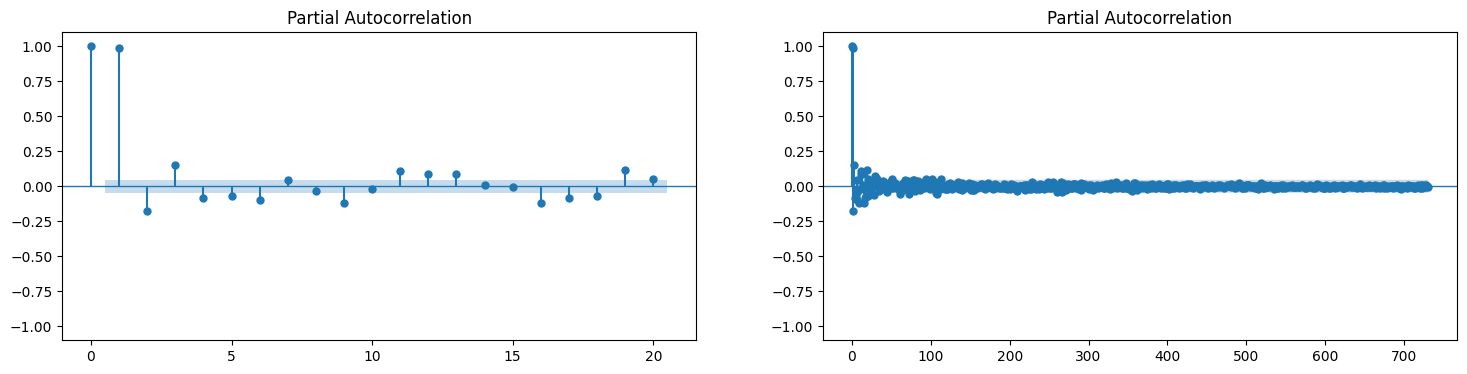

In [121]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 4))
axes = axes.flat
plot_pacf(datos[column], ax=axes[0], lags=20, method='ywm',  linewidth = 1) # ywm = Yule-Walker without adjustment
axes[0].set_ylim(-1.1, 1.1)
plot_pacf(datos[column], ax=axes[1], lags=730, method='ywm',  linewidth = 1)
axes[1].set_ylim(-1.1, 1.1)
plt.show()

## Entrenamiento

### Seleccion de fechas para entrenamiento y pruebas

In [122]:
start_train, end_train, start_test, end_test = getLimitDates(datos, 100, 1600) # 100 dias para test y 1600 para train

print(f"Historial completo      : {datos.index.min()} --- {datos.index.max()}  (n={len(datos)})")
print(f"Fechas de entrenamiento : {datos.loc[start_train:end_train].index.min()} --- {datos.loc[start_train:end_train].index.max()}  (n={len(datos.loc[start_train:end_train])})")
print(f"Fechas de prueba        : {datos.loc[start_test:].index.min()} --- {datos.loc[start_test:].index.max()}  (n={len(datos.loc[start_test:])})")

Historial completo      : 2017-11-09 00:00:00 --- 2022-09-25 00:00:00  (n=1782)
Fechas de entrenamiento : 2018-01-30 00:00:00 --- 2022-06-17 00:00:00  (n=1600)
Fechas de prueba        : 2022-06-18 00:00:00 --- 2022-09-25 00:00:00  (n=100)


### Modelo autoregresivo recursivo

## Evaluacion

### 1 Dia

Forecaster will be fit 100 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 

Forecaster will be fit 100 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 

Forecaster will be fit 100 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 

Forecaster will be fit 100 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 

Forecaster will be fit 100 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 

Forecaster will be fit 100 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 

Forecaster will be fit 100 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 



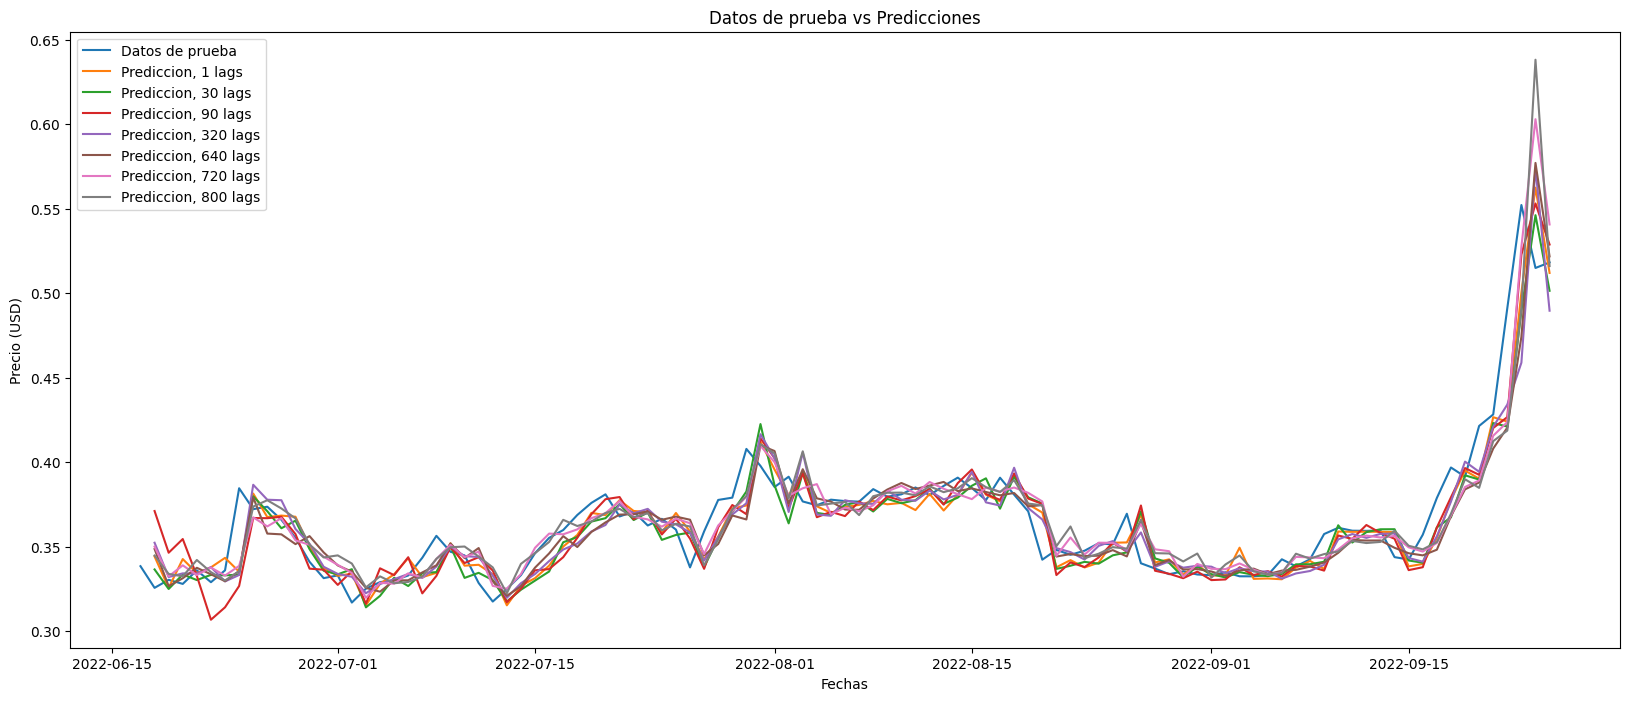

model  lags  test_error
0  LGBMRegressor     1    0.011288
1  LGBMRegressor    30    0.011558
2  LGBMRegressor    90    0.012182
3  LGBMRegressor   320    0.011762
4  LGBMRegressor   640    0.011637
5  LGBMRegressor   720    0.010801
6  LGBMRegressor   800    0.012090

In [123]:
steps = 1
lags = [1, 30, 90, 320, 640, 720, 800]
forecasters = train_and_show_predictions_and_errors(datos, start_train, end_train, column, lags, steps)

In [124]:
# Haciendo prediccion con el forecaster de 920 lags
print(forecasters[5].predict(10))

2022-06-18    0.350115
2022-06-19    0.341180
2022-06-20    0.344139
2022-06-21    0.352504
2022-06-22    0.354685
2022-06-23    0.355717
2022-06-24    0.352274
2022-06-25    0.346931
2022-06-26    0.344204
2022-06-27    0.345077
Freq: D, Name: pred, dtype: float64


### 14 Dias

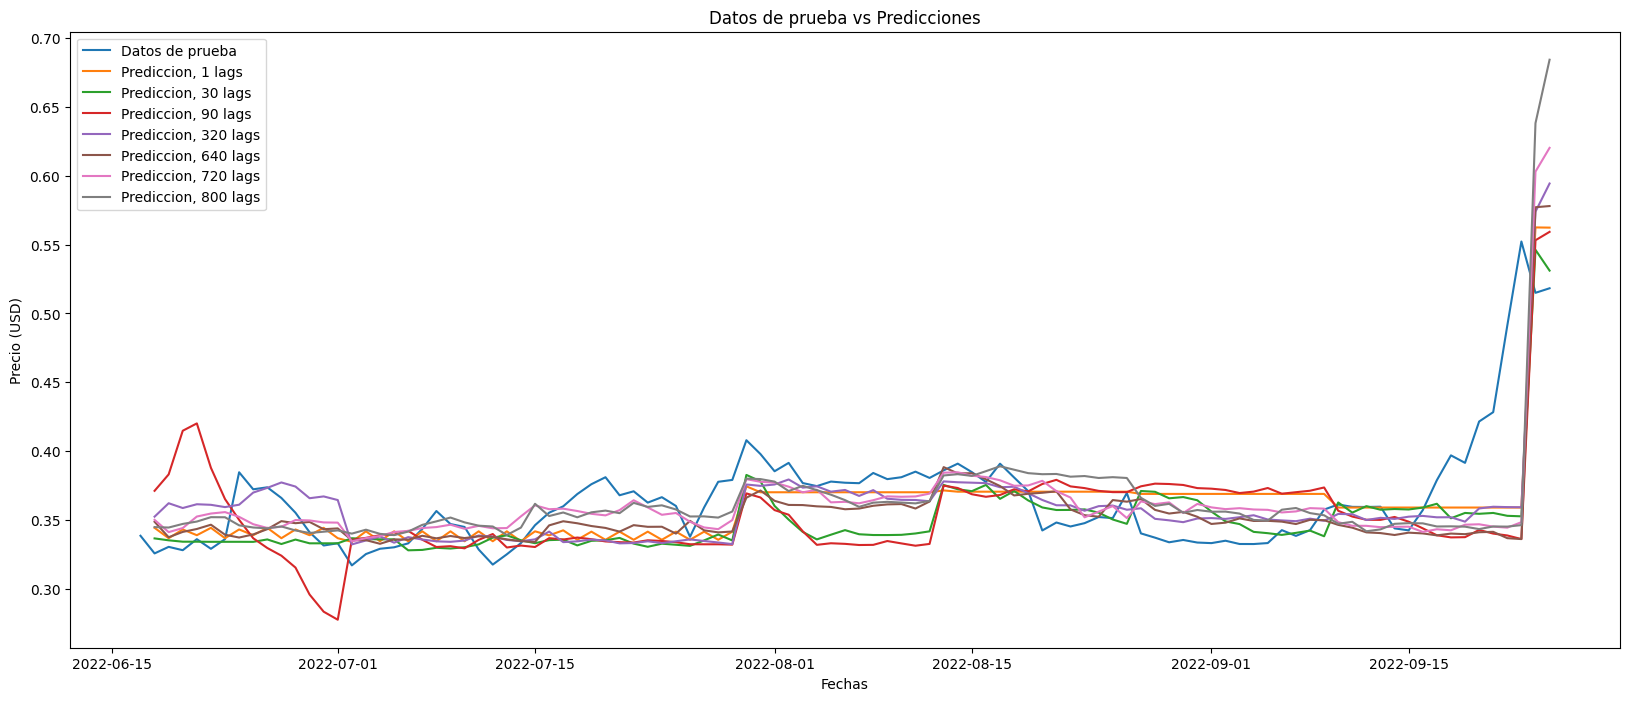

model  lags  test_error
0  LGBMRegressor     1    0.022743
1  LGBMRegressor    30    0.024195
2  LGBMRegressor    90    0.034757
3  LGBMRegressor   320    0.021895
4  LGBMRegressor   640    0.022507
5  LGBMRegressor   720    0.021873
6  LGBMRegressor   800    0.023539

In [125]:
steps = 14
forecasters = train_and_show_predictions_and_errors(datos, start_train, end_train, column, lags, steps)

### 1 Mes

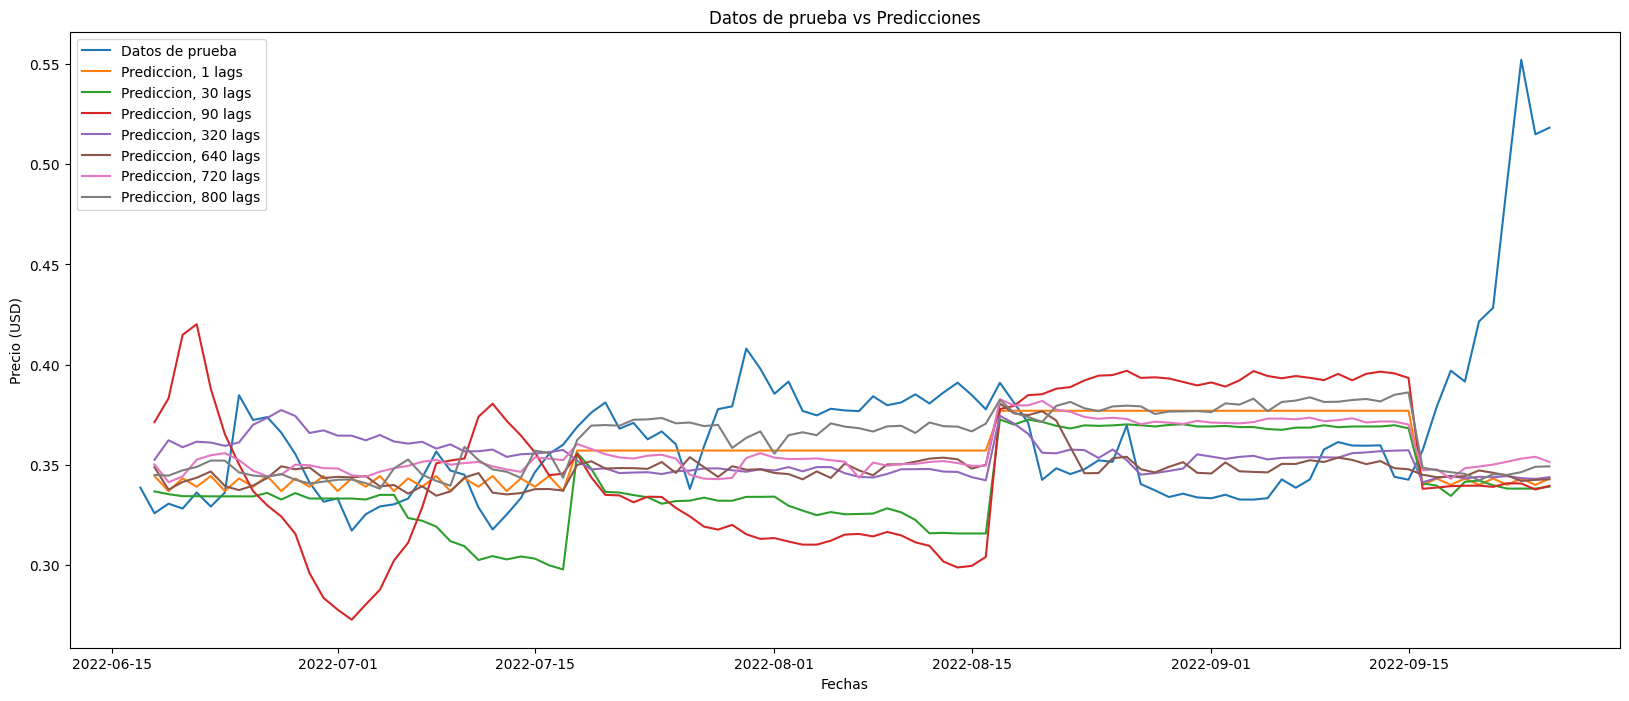

model  lags  test_error
0  LGBMRegressor     1    0.030013
1  LGBMRegressor    30    0.038394
2  LGBMRegressor    90    0.052826
3  LGBMRegressor   320    0.029774
4  LGBMRegressor   640    0.026710
5  LGBMRegressor   720    0.030163
6  LGBMRegressor   800    0.028738

In [126]:
steps = 30
forecasters = train_and_show_predictions_and_errors(datos, start_train, end_train, column, lags, steps)

### 6 Meses

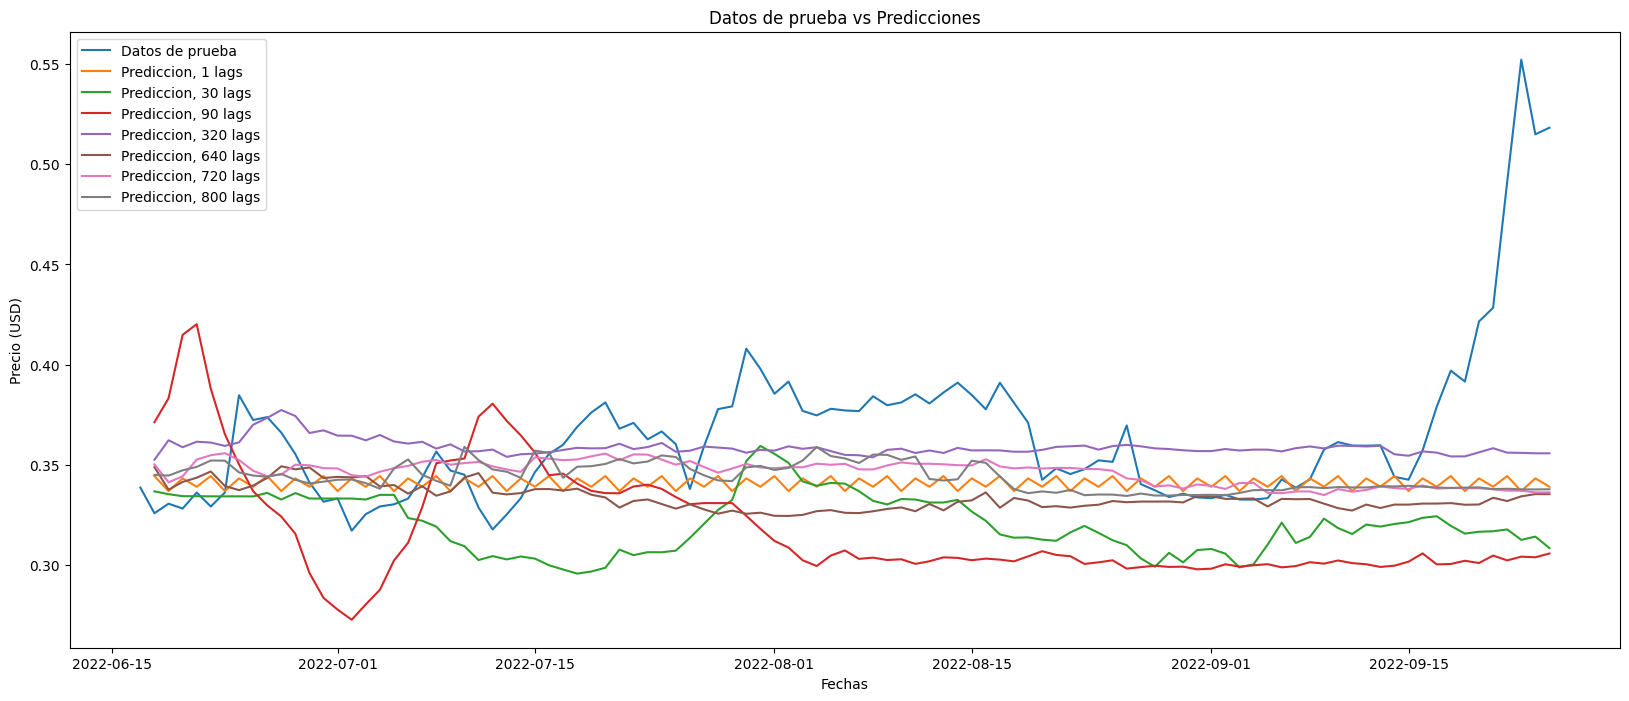

model  lags  test_error
0  LGBMRegressor     1    0.029358
1  LGBMRegressor    30    0.045414
2  LGBMRegressor    90    0.057937
3  LGBMRegressor   320    0.026558
4  LGBMRegressor   640    0.035578
5  LGBMRegressor   720    0.027292
6  LGBMRegressor   800    0.027851

In [127]:
steps = 180
forecasters = train_and_show_predictions_and_errors(datos, start_train, end_train, column, lags, steps)

### 1 Año

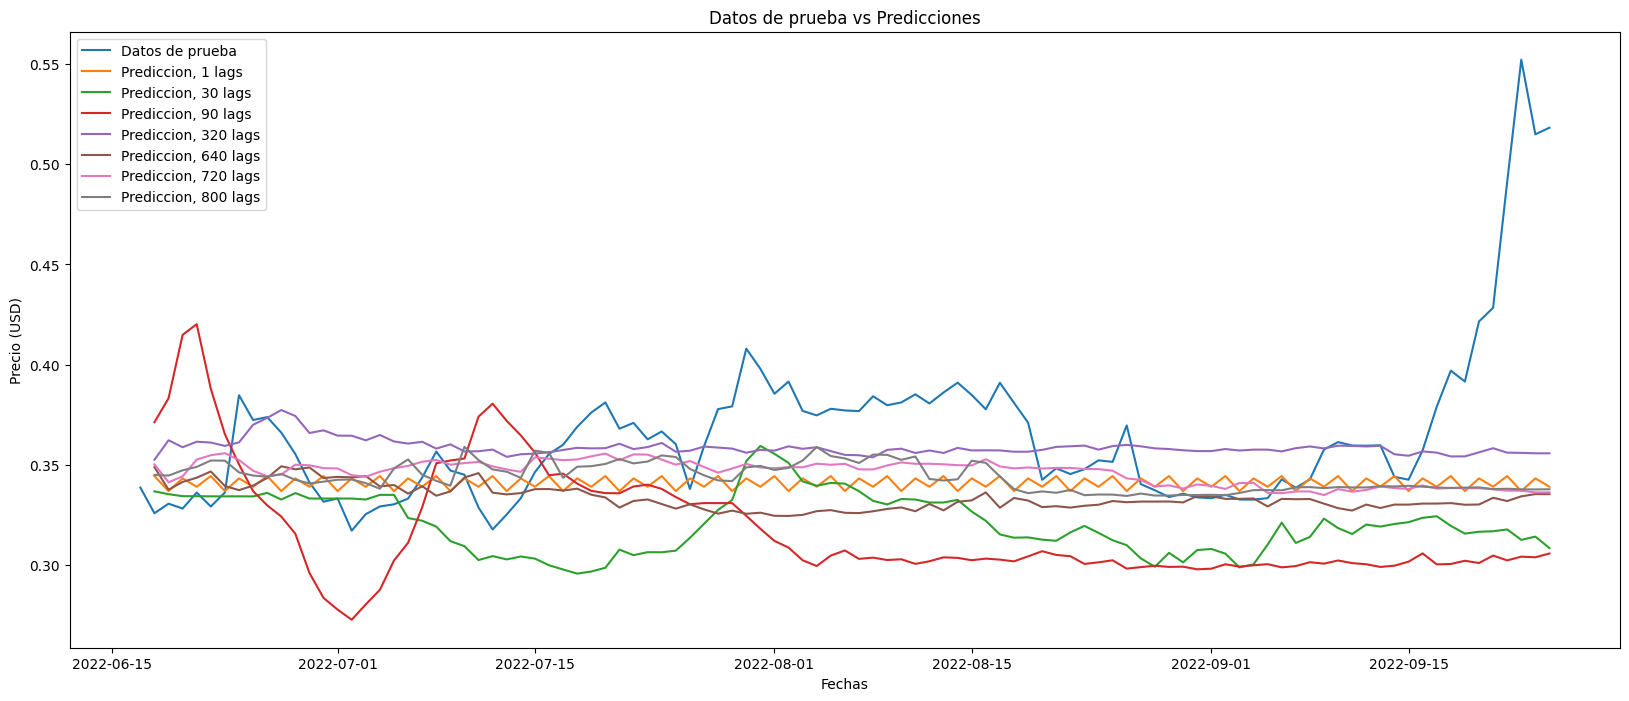

model  lags  test_error
0  LGBMRegressor     1    0.029358
1  LGBMRegressor    30    0.045414
2  LGBMRegressor    90    0.057937
3  LGBMRegressor   320    0.026558
4  LGBMRegressor   640    0.035578
5  LGBMRegressor   720    0.027292
6  LGBMRegressor   800    0.027851

In [128]:
steps = 365
forecasters = train_and_show_predictions_and_errors(datos, start_train, end_train, column, lags, steps)

# Solana

## Obtencion de los datos

In [129]:
# url para decargar todos los registros de Yahoo Finance, la fecha final es el dia de hoy menos un dia (ayer)
url = 'https://query1.finance.yahoo.com/v7/finance/download/SOL-USD?period1=1410825600&period2=' + getYesterdayEpoch() + '&interval=1d&events=history&includeAdjustedClose=true'

datos = downloadFile(url)
datos.info()
display(datos)
print(f"Fecha inicio datos: {datos.index.min()}")
print(f"Fecha fin datos: {datos.index.max()}")

<class 'pandas.core.frame.DataFrame'>
Index: 899 entries, 2020-04-10 to 2022-09-25
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       899 non-null    float64
 1   High       899 non-null    float64
 2   Low        899 non-null    float64
 3   Close      899 non-null    float64
 4   Adj Close  899 non-null    float64
 5   Volume     899 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 49.2+ KB


Open       High        Low      Close  Adj Close      Volume
Date                                                                         
2020-04-10   0.832005   1.313487   0.694187   0.951054   0.951054    87364276
2020-04-11   0.951054   1.049073   0.765020   0.776819   0.776819    43862444
2020-04-12   0.785448   0.956670   0.762426   0.882507   0.882507    38736897
2020-04-13   0.890760   0.891603   0.773976   0.777832   0.777832    18211285
2020-04-14   0.777832   0.796472   0.628169   0.661925   0.661925    16747614
...               ...        ...        ...        ...        ...         ...
2022-09-21  31.433790  33.133961  30.195068  30.826378  30.826378  1193686258
2022-09-22  30.815771  32.807045  30.638882  32.408905  32.408905   833702543
2022-09-23  32.406239  33.909164  31.363554  33.676636  33.676636   982495447
2022-09-24  33.675129  34.699177  33.274097  33.462650  33.462650   872691785
2022-09-25  33.461063  33.985237  32.014919  32.335361  32.335361   610529879

[899 rows x 6 columns]

Fecha inicio datos: 2020-04-10
Fecha fin datos: 2022-09-25


## Preparacion de los datos

In [130]:
column = 'High' # <--- Columna de valores a usar
datos['Date'] = pd.to_datetime(datos.index, format='%Y-%m-%d %H:%M:%S')
datos = datos.loc[:, ['Date', column]]
datos = datos.set_index('Date')
datos = datos.asfreq('D')
datos = datos.sort_index()
datos.head

<bound method NDFrame.head of                  High
Date                 
2020-04-10   1.313487
2020-04-11   1.049073
2020-04-12   0.956670
2020-04-13   0.891603
2020-04-14   0.796472
...               ...
2022-09-21  33.133961
2022-09-22  32.807045
2022-09-23  33.909164
2022-09-24  34.699177
2022-09-25  33.985237

[899 rows x 1 columns]>

In [131]:
# Verificar datos faltantes
print(f'Numero de filas con valores faltantes: {datos.isnull().any(axis=1).mean()}')

Numero de filas con valores faltantes: 0.0


### Analisis de datos

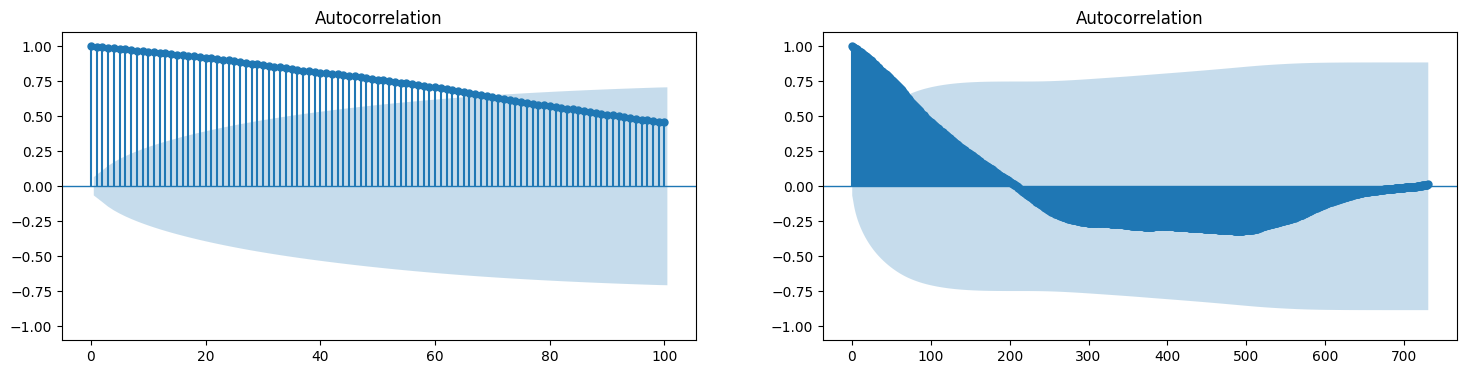

In [132]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 4))
axes = axes.flat
plot_acf(datos[column], ax=axes[0], linewidth = 1, lags=100)
axes[0].set_ylim(-1.1, 1.1)
plot_acf(datos[column], ax=axes[1], linewidth = 1, lags=730)
axes[1].set_ylim(-1.1, 1.1)
plt.show()

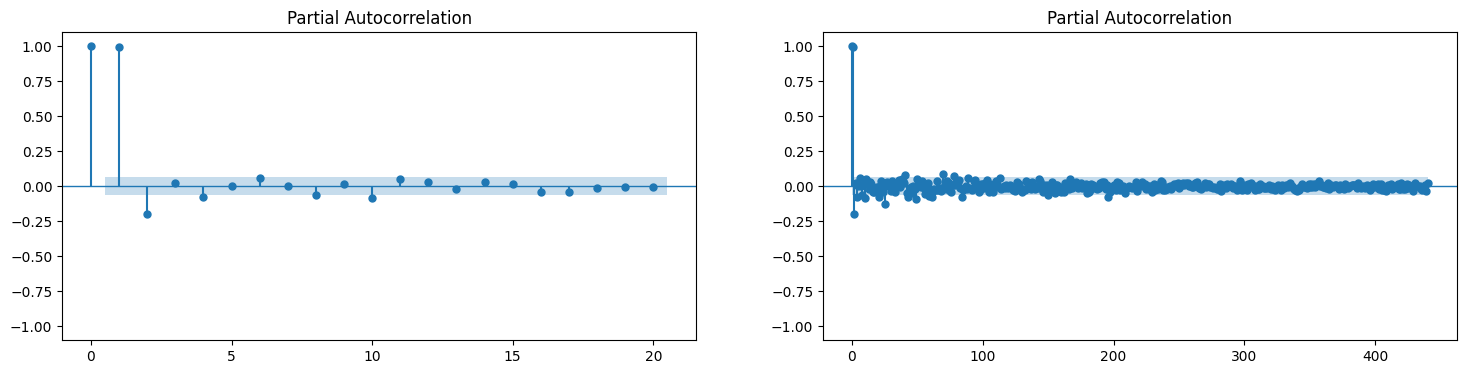

In [135]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 4))
axes = axes.flat
plot_pacf(datos[column], ax=axes[0], lags=20, method='ywm',  linewidth = 1) # ywm = Yule-Walker without adjustment
axes[0].set_ylim(-1.1, 1.1)
plot_pacf(datos[column], ax=axes[1], lags=440, method='ywm',  linewidth = 1)
axes[1].set_ylim(-1.1, 1.1)
plt.show()

## Entrenamiento

### Seleccion de fechas para entrenamiento y pruebas

In [137]:
start_train, end_train, start_test, end_test = getLimitDates(datos, 100, 800) # 100 dias para test y 1600 para train

print(f"Historial completo      : {datos.index.min()} --- {datos.index.max()}  (n={len(datos)})")
print(f"Fechas de entrenamiento : {datos.loc[start_train:end_train].index.min()} --- {datos.loc[start_train:end_train].index.max()}  (n={len(datos.loc[start_train:end_train])})")
print(f"Fechas de prueba        : {datos.loc[start_test:].index.min()} --- {datos.loc[start_test:].index.max()}  (n={len(datos.loc[start_test:])})")

Historial completo      : 2020-04-10 00:00:00 --- 2022-09-25 00:00:00  (n=899)
Fechas de entrenamiento : 2020-04-10 00:00:00 --- 2022-06-17 00:00:00  (n=799)
Fechas de prueba        : 2022-06-18 00:00:00 --- 2022-09-25 00:00:00  (n=100)


### Modelo autoregresivo recursivo

## Evaluacion

### 1 Dia

Forecaster will be fit 100 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 

Forecaster will be fit 100 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 

Forecaster will be fit 100 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 

Forecaster will be fit 100 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 

Forecaster will be fit 100 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 



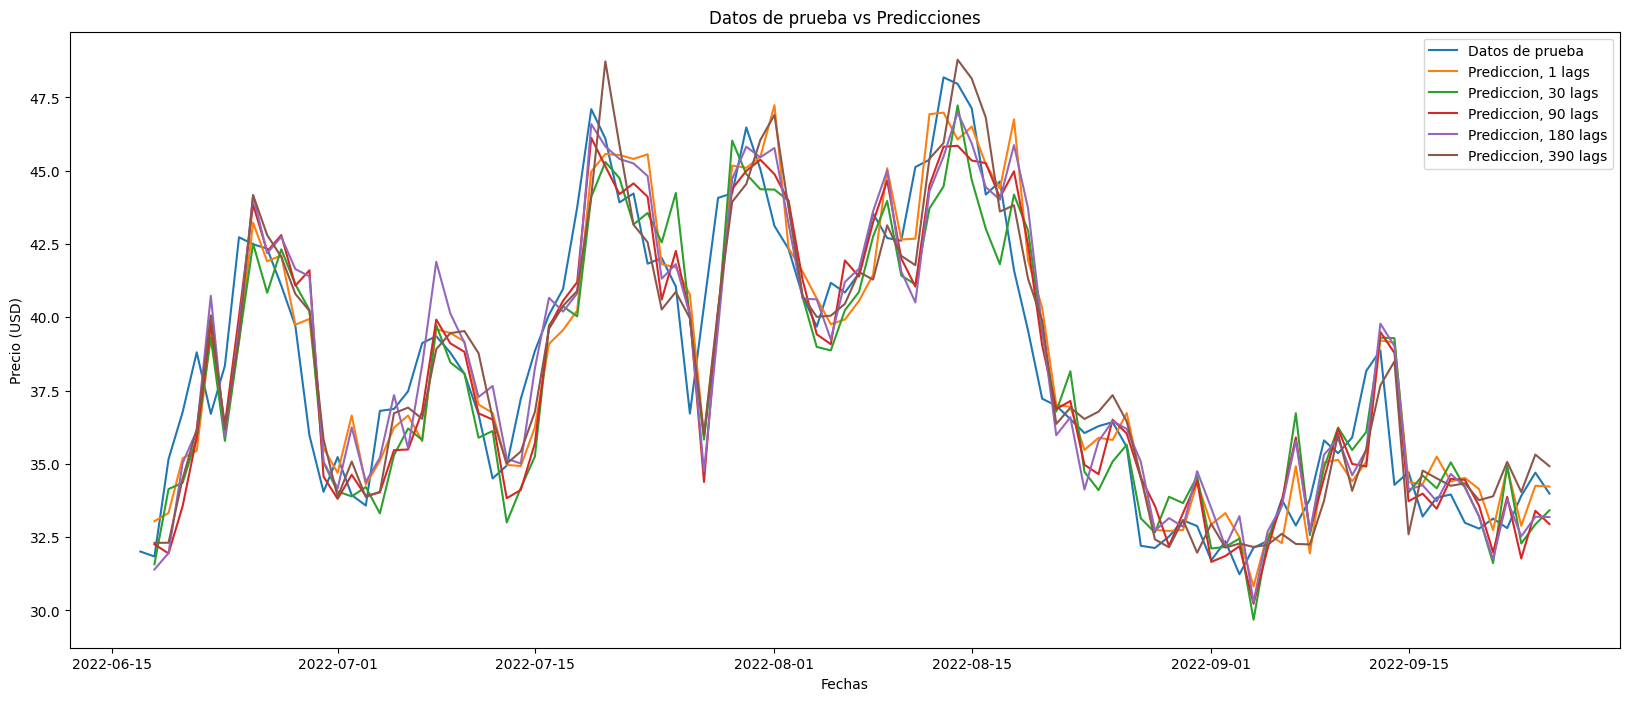

model  lags  test_error
0  LGBMRegressor     1    1.482711
1  LGBMRegressor    30    1.589827
2  LGBMRegressor    90    1.482268
3  LGBMRegressor   180    1.513106
4  LGBMRegressor   390    1.427811

In [149]:
steps = 1
lags = [1, 30, 90, 180, 390]
forecasters = train_and_show_predictions_and_errors(datos, start_train, end_train, column, lags, steps)

In [150]:
# Haciendo prediccion con el forecaster de 920 lags
print(forecasters[4].predict(10))

2022-06-18    32.305399
2022-06-19    32.208452
2022-06-20    31.931342
2022-06-21    32.158728
2022-06-22    32.339264
2022-06-23    32.751511
2022-06-24    32.632669
2022-06-25    33.064589
2022-06-26    33.241304
2022-06-27    33.241304
Freq: D, Name: pred, dtype: float64


### 14 Dias

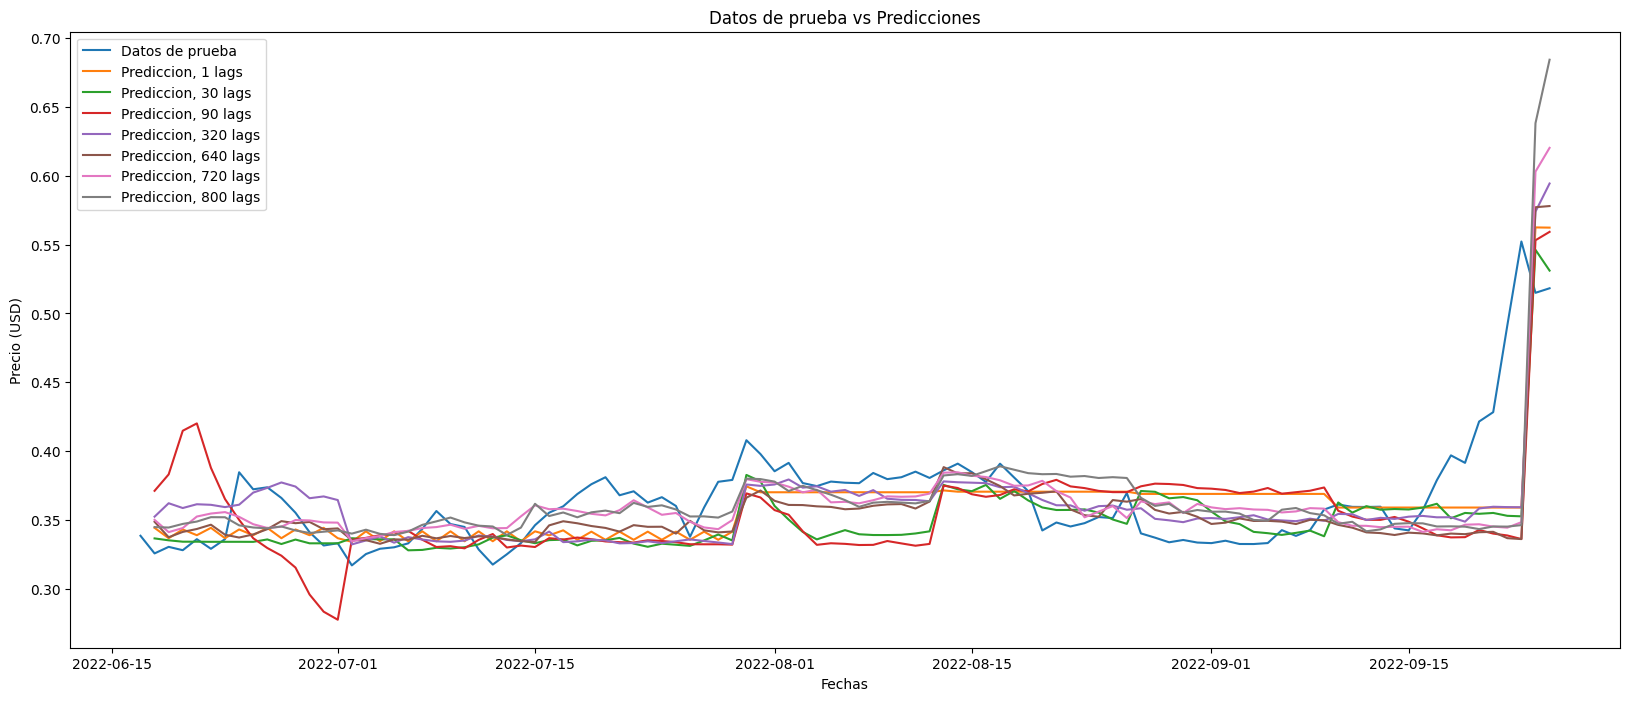

model  lags  test_error
0  LGBMRegressor     1    0.022743
1  LGBMRegressor    30    0.024195
2  LGBMRegressor    90    0.034757
3  LGBMRegressor   320    0.021895
4  LGBMRegressor   640    0.022507
5  LGBMRegressor   720    0.021873
6  LGBMRegressor   800    0.023539

In [ ]:
steps = 14
forecasters = train_and_show_predictions_and_errors(datos, start_train, end_train, column, lags, steps)

### 1 Mes

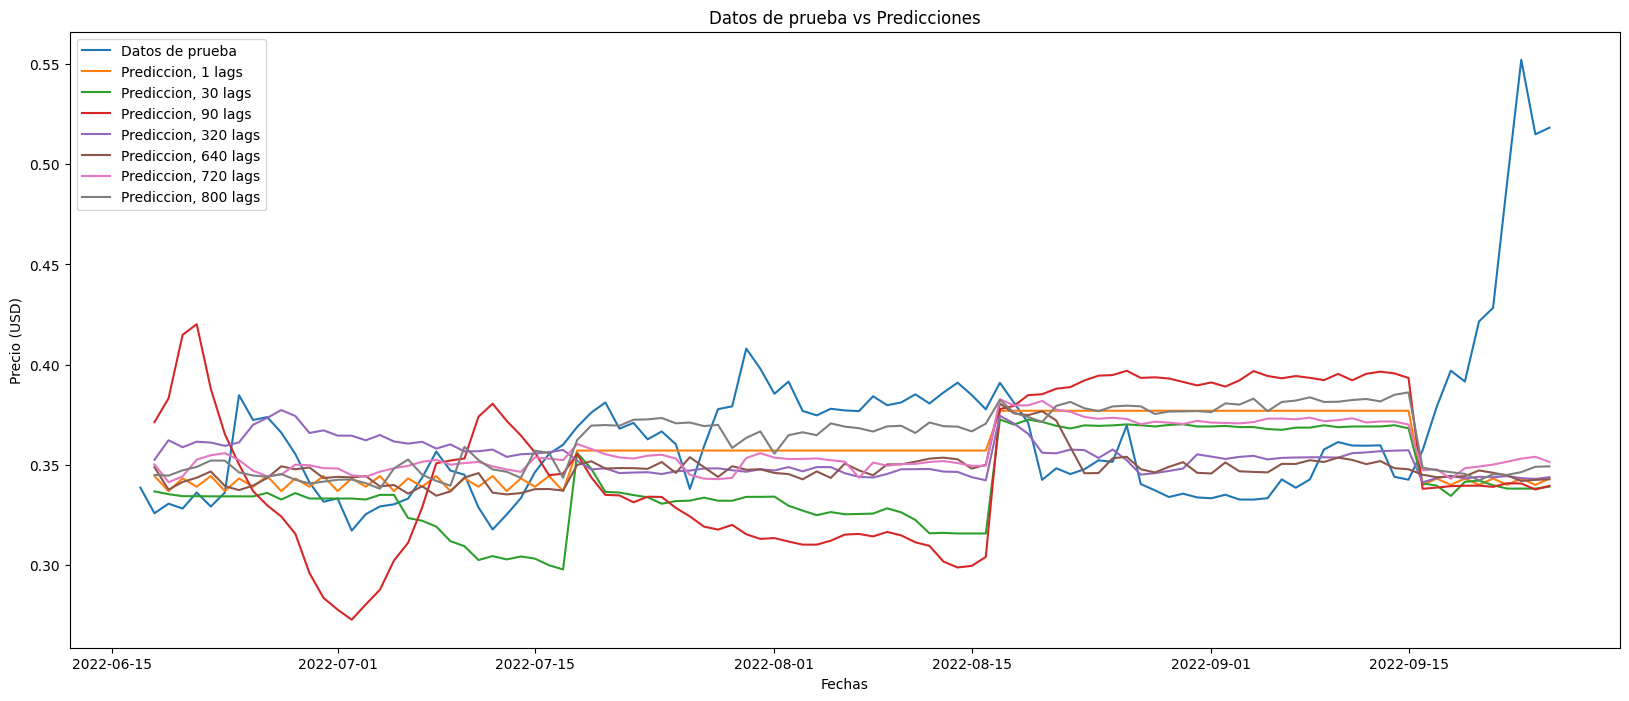

model  lags  test_error
0  LGBMRegressor     1    0.030013
1  LGBMRegressor    30    0.038394
2  LGBMRegressor    90    0.052826
3  LGBMRegressor   320    0.029774
4  LGBMRegressor   640    0.026710
5  LGBMRegressor   720    0.030163
6  LGBMRegressor   800    0.028738

In [ ]:
steps = 30
forecasters = train_and_show_predictions_and_errors(datos, start_train, end_train, column, lags, steps)

### 6 Meses

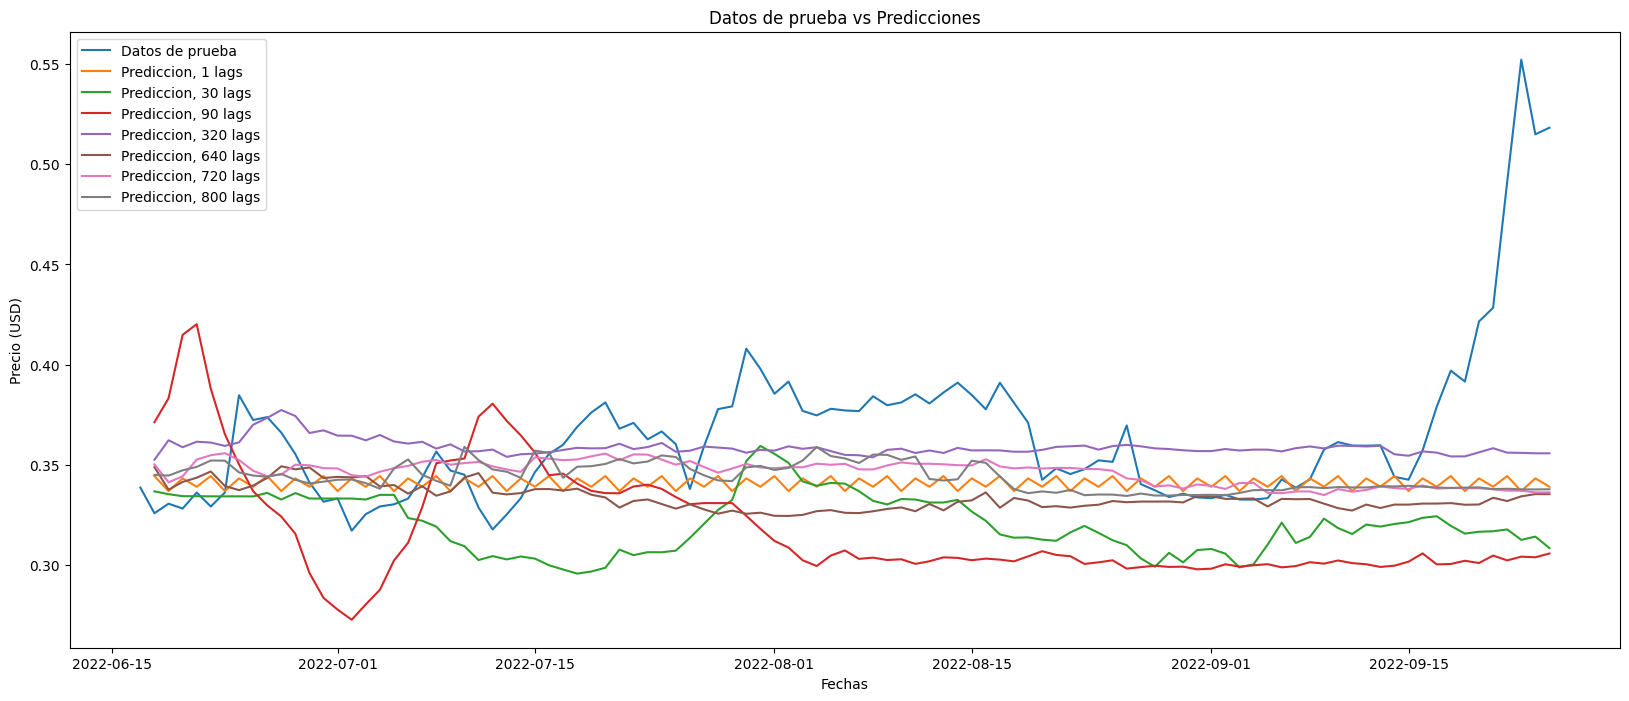

model  lags  test_error
0  LGBMRegressor     1    0.029358
1  LGBMRegressor    30    0.045414
2  LGBMRegressor    90    0.057937
3  LGBMRegressor   320    0.026558
4  LGBMRegressor   640    0.035578
5  LGBMRegressor   720    0.027292
6  LGBMRegressor   800    0.027851

In [ ]:
steps = 180
forecasters = train_and_show_predictions_and_errors(datos, start_train, end_train, column, lags, steps)

### 1 Año

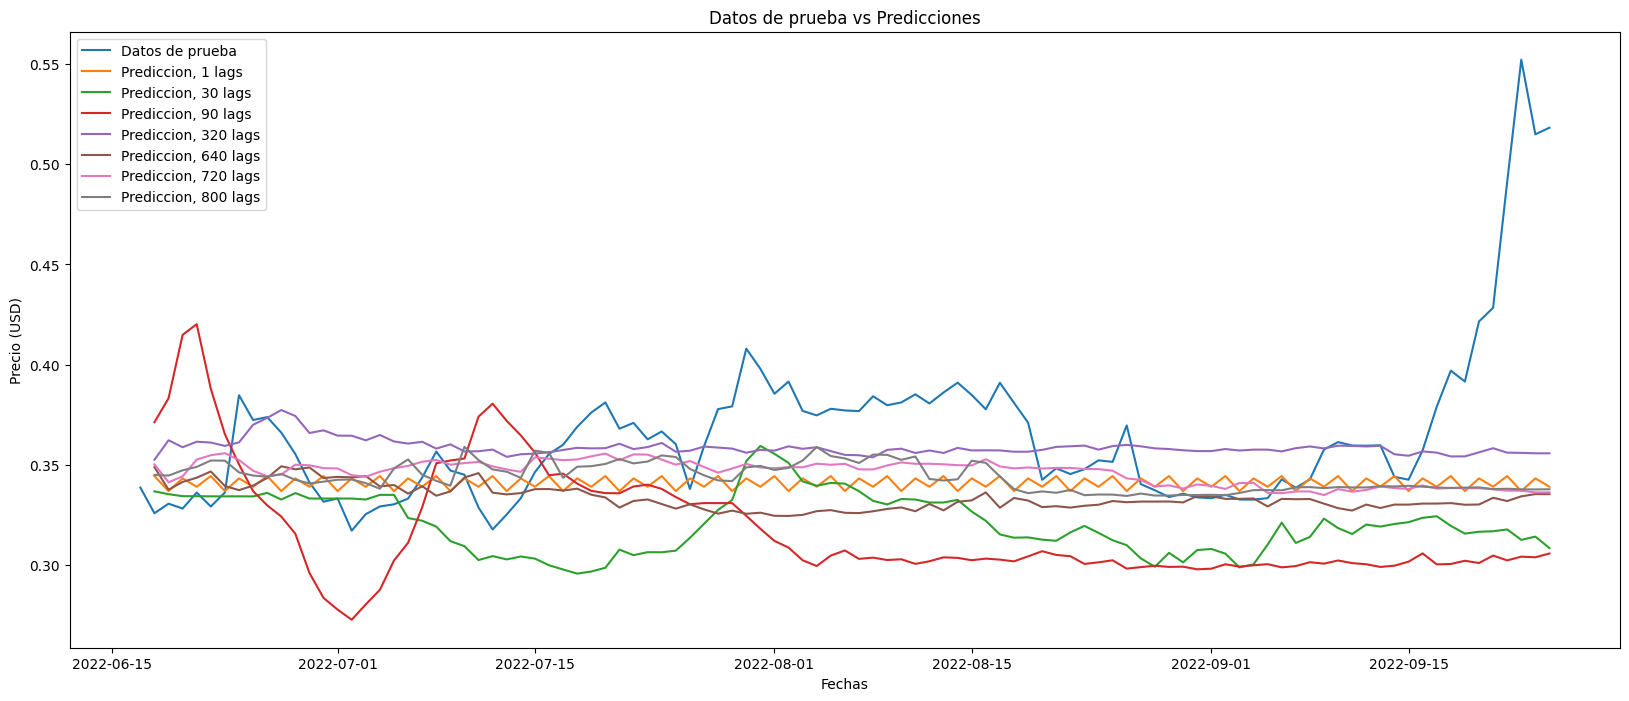

model  lags  test_error
0  LGBMRegressor     1    0.029358
1  LGBMRegressor    30    0.045414
2  LGBMRegressor    90    0.057937
3  LGBMRegressor   320    0.026558
4  LGBMRegressor   640    0.035578
5  LGBMRegressor   720    0.027292
6  LGBMRegressor   800    0.027851

In [ ]:
steps = 365
forecasters = train_and_show_predictions_and_errors(datos, start_train, end_train, column, lags, steps)